## Campaign altitude: EGU version




In [23]:
# imports from packages
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec # gridspec for nested subfigures
import matplotlib.dates as mdates
import cartopy.crs as ccrs
import cartopy.feature as creature
import glob
import os
import sys # to test parts of code with sys.exit()
import math
import seaborn as sns

import functions
import numb_conc # functions relating to number concenctration calculations
import plots


In [24]:
# --- Global formatting/settings/variables

# formatting for only showing time on the x-axis for plots per flight
# Use by setting axs[1,0].xaxis.set_major_formatter(formatter) for each axis where only time should show
formatter = mdates.DateFormatter('%H:%M')

# --- Thresholds for in-cloud values
# ----- Water content threshold
# following the korolev 22 paper: "In the present study the thresholds for liquid water content and ice water content (IWC) 
# were set as LWC > 0.01 g m−3, IWC > 0.01 g m−3, respectively. The phase composition of clouds was identified based on the 
# assessment of the ice water fraction mu = IWC∕(LWC + IWC). Thus, clouds with mu=0.9 were considered as ice, 
# clouds with Mu =0.1 were defined as liquid, 
# and clouds 0.1 ≤ 𝜇𝜇 ≤ 0.9 were determined as mixed-phase clouds."
lwc_th = 0.01

# ----- Number concentration threshold
# Following table 2 from Evans et al 2025:
# Ice concentration threshold to define ice = 0.1 L-1 (or m-3) (NT100 is given in m-3)
# Cdp drop concentration to define liquid = 2 cm-3 (numb conc corrected is given in cm-3)

n_ice_th = 0.1
n_drp_th = 2

# --- Select preselect options

# ----- In cloud threshold method
# Options:
# - 'LWC_th' based on only LWC
# - 'TWC_th' based on only TWC
# - 'LWC_IWC_th' based on LWC and IWC
# - 'N_th' based on number concentration from both CDP and CIP
th_method = 'LWC_IWC_th'

# --- Preselection options

#preselect = False # whether or not to use any preselection (sea/above70 degrees, latitude bin selections)
preselect = True # whether or not to use any preselection (sea/above70 degrees, latitude bin selections)

preopt = ''
rm_cirrus = True # remove cirrus by only looking at
rm_c_T = -30
marine = True # only use marine values (values larger than given lat)
m_lat = 70
rm_precip = False # remove precip based on selection


# set saving paths based on preselection options
if preselect == False:
    pre_text=''
    if rm_cirrus == True:
        preopt = preopt + f'rmCir{rm_c_T}_'
        pre_text = pre_text + f'Cirrus removed (>{rm_c_T}), '
    if marine == True:
        preopt = preopt + f'mar{m_lat}_'
        pre_text = pre_text + f'only marine (lat>70), '
    if rm_precip == True:
        preopt = preopt + f'rmPre{m_lat}_'
        pre_text = pre_text + f'Precip removed, '
        
    save_path = 'Latitudebands/Pre_selection/' #+preopt 
    
else:
    #save_path = 'Latitudebands/Alldata/'
    #save_path = 'Latitudebands/EGU/'
    save_path = 'Latitudebands/sample_rate/'
    pre_text = 'no preselect'
    
extr_txt = ''
#extr_txt = '(allin_off)'

In [25]:
# --- Data import
# Import the processed data:
main_path = '../Results_2022-islas/Processed/ISLAS_processed' # regular path
#main_path = '../Results_2022-islas/temp/with_MET/ISLAS_processed' # with met
#main_path = '../Results_2022-islas/temp/allin_off/Processed/ISLAS_processed' # testing path
file_struct = '/microphy_5s_*.nc' # structure of cip text-file names


# get all the .nc files in the main path
files = glob.glob(os.path.join(main_path, file_struct))
files = glob.glob(main_path+file_struct)

# Exclude the file containing 'IS22-09' (flew over land)
files_to_exclude = [f for f in files if 'IS22-09' in os.path.basename(f)]
files_to_include = [f for f in files if f not in files_to_exclude]


ds = xr.open_mfdataset(files_to_include, combine='by_coords', combine_attrs='drop_conflicts') # drop the IS22-09 flight
#ds = xr.open_mfdataset(main_path+file_struct, combine='by_coords', combine_attrs='drop_conflicts') # use all flights 
ds


<xarray.Dataset> Size: 86MB
Dimensions:                 (time: 22392, Vector64: 64, Vector40: 40,
                             CDP_Bin: 30)
Coordinates:
  * time                    (time) datetime64[ns] 179kB 2022-03-22T11:37:21 ....
    lat                     (time) float32 90kB dask.array<chunksize=(2358,), meta=np.ndarray>
    lon                     (time) float32 90kB dask.array<chunksize=(2358,), meta=np.ndarray>
    alt                     (time) float32 90kB dask.array<chunksize=(2358,), meta=np.ndarray>
  * CDP_Bin                 (CDP_Bin) int64 240B 1 2 3 4 5 6 ... 26 27 28 29 30
    islasid                 (time) <U7 627kB 'IS22-02' 'IS22-02' ... 'IS22-11'
Dimensions without coordinates: Vector64, Vector40
Data variables: (12/70)
    base_time               (time) datetime64[ns] 179kB 2022-03-22T11:37:21 ....
    utc_time                (time) float64 179kB dask.array<chunksize=(2358,), meta=np.ndarray>
    TAS                     (time) float32 90kB dask.array<chunksize=(2358,), meta=np.ndarray>
    MIDBINS                 (time, Vector64) float32 6MB dask.array<chunksize=(2358, 64), meta=np.ndarray>
    ACTIVETIME              (time) float32 90kB dask.array<chunksize=(2358,), meta=np.ndarray>
    SA                      (time, Vector64) float32 6MB dask.array<chunksize=(2358, 64), meta=np.ndarray>
    ...                      ...
    TAS reduce              (time) float32 90kB dask.array<chunksize=(2358,), meta=np.ndarray>
    TAS correction factor   (time) float64 179kB dask.array<chunksize=(2358,), meta=np.ndarray>
    Number Conc corr        (time) float64 179kB dask.array<chunksize=(2358,), meta=np.ndarray>
    LWC corr                (time) float64 179kB dask.array<chunksize=(2358,), meta=np.ndarray>
    SV                      (time) float32 90kB dask.array<chunksize=(2358,), meta=np.ndarray>
    SV_CDP                  (time) float32 90kB dask.array<chunksize=(2358,), meta=np.ndarray>
Attributes:
    date_modified:            2025-05-22
    Joint sample rate (sek):  5.0

In [26]:
#---- Select incloud, relevant values

# commenting out all other masks for the EGU version

# Masks for different types of selections 
#relevant_mask = (ds['Relevance']=='Lower clouds').compute() # mask for selecting only the lower clouds
#lwc_mask = (ds['LWC corr']>=lwc_th).compute() # mask the values based on lwc according to threshold
#twc_mask = (ds['TWC']>=lwc_th).compute() # mask the values based on twc according to threshold
lwc_iwc_mask = ((ds['LWC corr']>= lwc_th)|(ds['IWC100']>= lwc_th)).compute() # mask the values based on lwc or iwc according to threshold
#nt_mask = ((ds['Number Conc corr']>= n_drp_th)|(ds['NT100']>= n_ice_th)).compute()

# precipitation masking
#precip_mask = ((ds.IWC100 >= 0.01) & (ds['LWC corr'] < 0.001)).compute() # mask values that are not precip, define precip region as where LWC < 0.001 or 0.005 and IWC >= 0.01
 

# --- First selection: all data or only lower clouds/relevant data, only marine data
if preselect == True:
    # select only marine values (lat higher than 70)
    if marine == True:
        marinelat_mask = (ds['lat']>=m_lat).compute()
        ds_relevant = ds.where(marinelat_mask, drop = True)

    if rm_cirrus == True:
        # select only values where temperature is higher than selected temperature (avoid cirrus)
        cirrusT_mask = (ds['T']>=rm_c_T).compute()
        ds_relevant = ds_relevant.where(cirrusT_mask, drop = True)
else:
    ds_relevant = ds

# ---- Second selection: what should be considered in-cloud?
# th_method is used to selecting the selection criteria and is added to saved plots for organizing
if th_method == 'LWC_th':
    # only lwc have to be larger than threshold, use lwc mask
    incloud_mask = lwc_mask
    th = f'{lwc_th} m^-3, (LWC)'
elif th_method == 'TWC_th':
    # twc have to be larger than threshold value, use twc mask
    incloud_mask = twc_mask
    th = f'{lwc_th} m^-3, (TWC)'
elif th_method == 'LWC_IWC_th':
    # either lwc or iwc needs to be larger than the threshold, use lwc_iwc_mask
    incloud_mask = lwc_iwc_mask
    th = f'{lwc_th} m^-3, (LWC or IWC)'
elif th_method == 'N_th':
    incloud_mask = nt_mask
    th = f'Nt_cdp>{n_drp_th} cm^-3, Nt_cip100>{n_ice_th} L^-1'
else:
    print('WARNING: in-cloud threshold method not defined!')

# create the selected dataset based on selected mask
ds_incloud = ds_relevant.where(incloud_mask, drop = True)

# --- Third selection: selection and removal of precip values

if rm_precip == True:
    # use the remove precip in all the plots
    ds_incloud = ds_incloud.where(~precip_mask, drop=True)
    
# store precip/noprecip separately: (Dont care about precip for EGU
#ds_incloud_noprecip = ds_incloud.where(~precip_mask, drop=True)# Remove precip from incloud
#ds_precip= ds_incloud.where(precip_mask, drop = True) # save only precip

# Printing sizes of datasets for overview:
print(f'Full dataset size: {len(ds.time)}')
print(f'Relevant dataset size: {len(ds_relevant.time)}')
print(f'In-cloud threshold: {lwc_th} g/m3')
#print(f'Incloud dataset (LWC_th) size: {len(ds_relevant.where(lwc_mask, drop=True).time)}')
#print(f'Incloud dataset (TWC_th) size: {len(ds_relevant.where(twc_mask, drop=True).time)}')
print(f'Incloud dataset (LWC_IWC_th) size: {len(ds_relevant.where(lwc_iwc_mask, drop=True).time)}')
print(f'Used dataset: {th_method}, size:{len(ds_incloud.time)}')
#print(f'Used dataset, no precip: size: {len(ds_incloud_noprecip.time)}')
#
# check if properly selected
#print(f'Relevance: {np.unique(ds_incloud.Relevance.values)}')
#print(len(ds_incloud['time']))
#print(f'threshold method: {th_method}')
#print(f'lowest lwc value: {ds_incloud['LWC corr'].values.min()}')
#print(f'lowest twc value: {ds_incloud['TWC'].values.min()}')
#print(f'lowest iwc value: {ds_incloud['IWC100'].values.min()}')
#print(len(ds_precip['time']))
#print(f'highest lwc value: {ds_precip['LWC corr'].values.max()}')
#print(f'lowest iwc value: {ds_precip['IWC100'].values.min()}')


Full dataset size: 22392
Relevant dataset size: 11858
In-cloud threshold: 0.01 g/m3
Incloud dataset (LWC_IWC_th) size: 5655
Used dataset: LWC_IWC_th, size:5655


In [27]:
# in-cloud "sample distances" based on 5 sek values over the max an min TAS
print(f'Min TAS: {ds_incloud.TAS.values.min()} m/s')
print(f'Min sample distance (5 s sample): {ds_incloud.TAS.values.min()*5} m')
print(f'Max TAS: {ds_incloud.TAS.values.max()} m/s')
print(f'Max sample distance (5 s sample): {ds_incloud.TAS.values.max()*5} m')
print(f'max incloud altitude: {ds_incloud.alt.values.max()} m')
print(f'min incloud altitude: {ds_incloud.alt.values.min()} m')

Min TAS: 59.0 m/s
Min sample distance (5 s sample): 295.0 m
Max TAS: 130.0 m/s
Max sample distance (5 s sample): 650.0 m
max incloud altitude: 4460.13916015625 m
min incloud altitude: 83.09110260009766 m


In [28]:
# --- Preparations for altitude based plots
# create categorical altitude variable based on altitude values (for in-cloud, relevant and precip data

# Define the bin edges for the altitude (based on the incloud data
altitude_bins = np.arange(0, ds_incloud['alt'].max() + 300, 300) # based on max values in data
bin_labels = (altitude_bins[:-1] + altitude_bins[1:]) / 2
print(altitude_bins)

# need to add altitude binning information(based on in-cloud values) to all datasets 
def add_alt_bins(ds, altitude_bins):
    # digitize altitude data into bins
    alt_bin_indices = np.digitize(ds['alt'], bins = altitude_bins)

    ds = ds.assign_coords(altitude_bin=('time', alt_bin_indices)) # on 'time' dimension

    # Label bins by midpoints
    bin_labels = (altitude_bins[:-1] + altitude_bins[1:]) / 2
    ds['altitude_bin'].data = bin_labels[alt_bin_indices - 1]
    ds.coords['altitude_bin']=ds.coords['altitude_bin'].astype(int)
    return ds

# in-cloud
ds_incloud = add_alt_bins(ds_incloud, altitude_bins) # add altitude binning information

# relevant clouds (all data)
alt_mask = (ds_relevant['alt'] <= altitude_bins.max()).compute()
ds_relevant = ds_relevant.where(alt_mask, drop = True) 
ds_relevant = add_alt_bins(ds_relevant, altitude_bins) # add altitude binning information

[   0.  300.  600.  900. 1200. 1500. 1800. 2100. 2400. 2700. 3000. 3300.
 3600. 3900. 4200. 4500.]


In [29]:
# datapoints per altitude bins and statistics
print(f'#datapoints per altitudebin: {ds_incloud['altitude_bin'].groupby('altitude_bin').count().values}')
print(f'Min #datapoints: {ds_incloud['altitude_bin'].groupby('altitude_bin').count().values.min()}')
print(f'Max #datapoints: {ds_incloud['altitude_bin'].groupby('altitude_bin').count().values.max()}')
print(f'Mean #datapoints: {ds_incloud['altitude_bin'].groupby('altitude_bin').count().values.mean()}')

#datapoints per altitudebin: [ 223 1366  520  583 1120  584  229  155   32  432   22   21   87  281]
Min #datapoints: 21
Max #datapoints: 1366
Mean #datapoints: 403.92857142857144


In [30]:
# --- Functions (add to file later)
def plot_lat_bands(lat_bands, ds, ds_incloud, title, savefile = ''):
    # Function to plot latitude bands used for further analysis
    # Input: 
    # --- lat_bands: array of the the latitudes used for separation, should include at least min and max latitude
    # --- ds: full original dataset for plotting flightpaths
    # --- title: title to add to plot
    # --- savefile(optional): path and filename to save plot into

    # functions
    import cartopy.crs as ccrs
    import cartopy.feature as cfeature
    import matplotlib.pyplot as plt
    from matplotlib.gridspec import GridSpec # gridspec for nested subfigures

    # coordinates of Kiruna
    lat_kir = 67.8256
    lon_kir = 20.3351

    # set colors
    n_col='tab:blue'
    s_col='tab:red'
    
    # --- Set up figure
    fig = plt.figure(figsize=(20, 10))
    gs = GridSpec(1, 2, figure=fig)
    ax = fig.add_subplot(gs[0,0], projection=ccrs.NorthPolarStereo())

    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linewidth=2)
    data_projection = ccrs.PlateCarree()

    # get datavalues for plotting
    lat_values = ds['lat'].values
    lon_values = ds['lon'].values

    # select out northern marine in cloud values
    n_mask = (ds_incloud['region'] == 'north').compute()
    n_ds = ds_incloud.where(n_mask, drop=True)
    n_lat_values = n_ds['lat'].values
    n_lon_values = n_ds['lon'].values
    
    # select out southern marine in cloud values
    s_mask = (ds_incloud['region'] == 'south').compute()
    s_ds = ds_incloud.where(s_mask, drop=True)
    s_lat_values = s_ds['lat'].values
    s_lon_values = s_ds['lon'].values


    #ax.scatter(lon_values, lat_values, marker='.',c=incloud_values, transform = data_projection)
    ax.scatter(lon_values, lat_values, marker='.',c='darkgrey', label='Flight path', transform = data_projection)
    ax.scatter(n_lon_values, n_lat_values, marker='o',c=n_col, label=f'Northern marine region \n in-cloud ({len(n_lon_values)} obs)', transform = data_projection)
    ax.scatter(s_lon_values, s_lat_values, marker='o',c=s_col, label=f'Southern marine region \n in-cloud ({len(s_lon_values)} obs)', transform = data_projection)

    # Draw latitude bands
    for lat_band in lat_bands:
        ax.plot(range(0, 51, 5), [lat_band]*11, color='k', transform=ccrs.PlateCarree())
        if lat_band in [lat_min, lat_max]:
            lat_text = round(lat_band, 2)
        else:
            lat_text = lat_band
        ax.text(28, lat_band-0.9, f"{lat_text:.2f}°", transform=ccrs.PlateCarree(), ha='center', va='bottom', fontsize=20, color='k', 
                rotation=30, bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))

    # Text for northern and southern marine

    ax.text(30, 75.5, "Northern \n marine region", transform=ccrs.PlateCarree(), ha='center', va='bottom', fontsize=20, color=n_col, 
                rotation=30)
    ax.text(30, 71.5, "Southern \n marine \n region", transform=ccrs.PlateCarree(), ha='center', va='bottom', fontsize=20, color=s_col, 
                rotation=30)

    #Plot Kiruna 
    ax.plot(lon_kir, lat_kir, marker='o', color='tab:red', transform=data_projection)
    offset_lon = 0.7  # adjust the horizontal offset
    offset_lat = -0.7  # adjust the vertical offset
    ax.text(lon_kir + offset_lon, lat_kir + offset_lat, "Kiruna", transform=data_projection, ha='right', va='bottom')

    # set extent of the plot to the full area covered by the dataset +/- an increment of 1
    ax.set_extent([ds.lon.values.min()-5, ds.lon.values.max()+1, ds.lat.values.min()-1.5, ds.lat.values.max()+1])
    
    ax.set_title(f'{title}', fontsize = 25)

    plt.legend(loc='lower left', fontsize=16)
    plt.tight_layout()
    if savefile !='':
        plt.savefig(savefile)

def create_counts(ds, lat_bins):
    # Function to create counts array tu use when making heatmaps. Keeps control of normalizations etc.
    # Input: 
    # --- ds: dataset, that at least have 'base_time' and an altitude as parameters
    # --- lat_bins: title to add to plot
    # output:
    # --- count_df: df ouf number of observations per latitudebin and altitude bin for the given dataset

    grouped_data = ds['base_time'].groupby_bins('lat', bins=lat_bins) #group on lat binsbins
    
    count_data = grouped_data.map(lambda group: group.groupby('altitude_bin').count())
    
    # reorganize data before plotting heatmap
    # - turn into dataframe - unstack to get correct array structure  
    count_df = count_data.to_dataframe().unstack()
    
    # - transpose to get altitude on y-axis - reset index and drop outer index(base_time)
    count_df = count_df.T.reset_index(level=0, drop = True)
    # -  make sure all possible altitude bins are represented, fill with 0 - reverse order of altitudes
    count_df = count_df.reindex(bin_labels, fill_value=0).iloc[::-1] #
    count_df = count_df.fillna(0) # set nan to 0 (for easier plot management)
    count_df = count_df.astype(int) # set the count to int
    count_df = count_df.iloc[:, ::-1] # reverse the columns to get the northern most values to the left
    #fix labels 
    new_labels = [f"[{label.right}, {label.left})" for label in count_df.columns]
    count_df.columns = new_labels
    
    return count_df

def calculate_slf(ds, iwc_param, lwc_param):
    """Calculate Supercooled liquid fraction(SLF) from given IWC and LWC parameters

    Parameters
    ----------
    ds
        xarray dataset that includes at least one IWC parameter and at least one LWC parameter
    iwc_param
        Name of IWC parameter to use for calculation of SLF
    lwc_param
        Name of LWC parameter to use for calculation of SLF

    Returns
    -------
    ds
        Updated xarray dataset that includes TWC and SLF calculated from the given IWC and LWC parameters
    """
    ds['TWC'] = ds[iwc_param]+ds[lwc_param] # first calculate TWC
    # update TWC attributes
    ds['TWC'].attrs['longname']='Total Water Content'
    ds['TWC'].attrs['unit']='g/m^3'
    ds['TWC'].attrs['description']='Sum of Liquid and Ice Water Content'
    ds['TWC'].attrs['calculated from']=[iwc_param,lwc_param]

    ds['SLF'] = (ds[lwc_param]/ds['TWC'])*100 # calculate SLF in percent
    ds['SLF'].attrs['longname']='Supercooled Liquid Fraction'
    ds['SLF'].attrs['unit']='Percent'
    ds['SLF'].attrs['description']='Liquid Water Content divided by Total Water Content'
    ds['SLF'].attrs['calculated from']=[lwc_param, 'TWC']

    
    return ds

In [31]:
ds_incloud = calculate_slf(ds_incloud,'IWC100','LWC corr')
ds_incloud

<xarray.Dataset> Size: 22MB
Dimensions:                 (time: 5655, Vector64: 64, Vector40: 40, CDP_Bin: 30)
Coordinates:
  * time                    (time) datetime64[ns] 45kB 2022-03-22T11:39:01 .....
  * CDP_Bin                 (CDP_Bin) int64 240B 1 2 3 4 5 6 ... 26 27 28 29 30
    lat                     (time) float32 23kB 70.2 70.22 70.22 ... 74.96 74.95
    lon                     (time) float32 23kB 20.38 20.37 ... 20.88 20.88
    alt                     (time) float32 23kB 3.863e+03 3.866e+03 ... 840.7
    islasid                 (time) <U7 158kB 'IS22-02' 'IS22-02' ... 'IS22-11'
    altitude_bin            (time) int64 45kB 3750 3750 3750 ... 450 750 750
Dimensions without coordinates: Vector64, Vector40
Data variables: (12/72)
    base_time               (time) datetime64[ns] 45kB 2022-03-22T11:37:21 .....
    utc_time                (time) float64 45kB dask.array<chunksize=(1976,), meta=np.ndarray>
    TAS                     (time) float32 23kB dask.array<chunksize=(1976,), meta=np.ndarray>
    MIDBINS                 (time, Vector64) float32 1MB dask.array<chunksize=(1976, 64), meta=np.ndarray>
    ACTIVETIME              (time) float32 23kB dask.array<chunksize=(1976,), meta=np.ndarray>
    SA                      (time, Vector64) float32 1MB dask.array<chunksize=(1976, 64), meta=np.ndarray>
    ...                      ...
    Number Conc corr        (time) float64 45kB dask.array<chunksize=(1976,), meta=np.ndarray>
    LWC corr                (time) float64 45kB dask.array<chunksize=(1976,), meta=np.ndarray>
    SV                      (time) float32 23kB dask.array<chunksize=(1976,), meta=np.ndarray>
    SV_CDP                  (time) float32 23kB dask.array<chunksize=(1976,), meta=np.ndarray>
    TWC                     (time) float64 45kB dask.array<chunksize=(1976,), meta=np.ndarray>
    SLF                     (time) float64 45kB dask.array<chunksize=(1976,), meta=np.ndarray>
Attributes:
    date_modified:            2025-05-22
    Joint sample rate (sek):  5.0

## Plots

In [32]:
lon_min = ds_incloud.lon.values.min() # use ds-sea_lat to exclude the few sea datapoints too far south moving the division line too far south
lon_max = ds_incloud.lon.values.max()

sample_rate = int(ds_incloud.attrs['Joint sample rate (sek)']) # get sample rate for file naming

print(lon_min, lon_max)

6.9966335 24.792715


number of values in 2 bands defined by [np.float32(70.00316), np.float32(74.15311), np.float32(78.303055)]:
count_south: 3619,count_north: 2035
Latitudebands/sample_rate/Latitude_bands_regions_5s_LWC_IWC_th.png


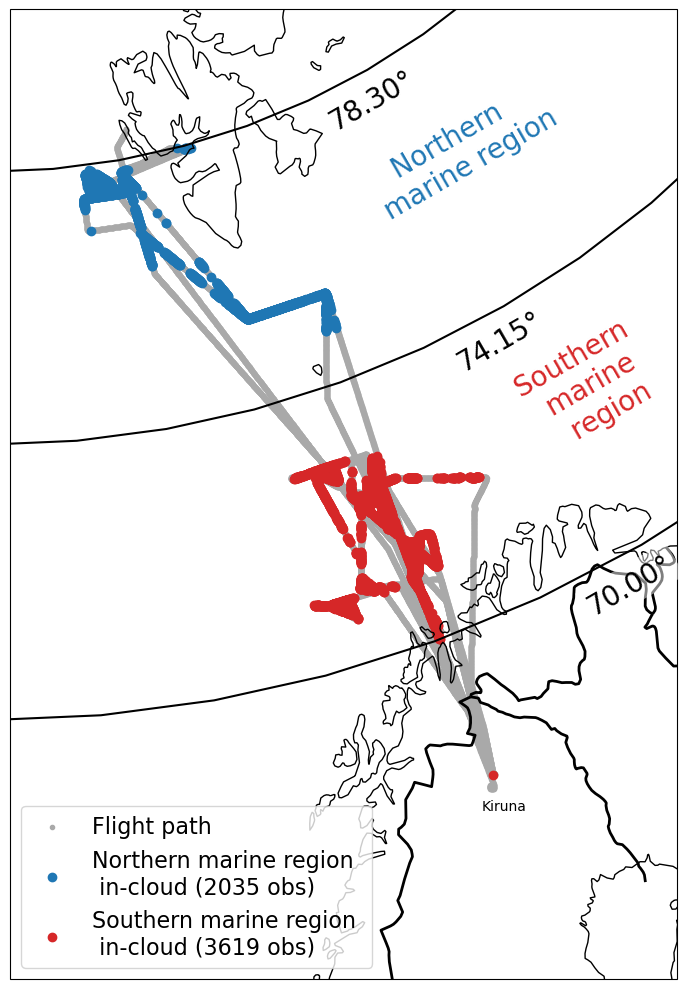

In [33]:
# --- Split for southern marine, northern marine and land datasets (in cloud)

# --- plotting division areas
# Define latitudes to set as boundaries
lat_min = ds_incloud.lat.values.min() # use ds-sea_lat to exclude the few sea datapoints too far south moving the division line too far south
lat_max = ds_incloud.lat.values.max()
lat_mid = lat_min + ((lat_max-lat_min)/2) # separation point for the southern marine and northern marine

# set lat-bands to compute between (as an array)
lat_bands = [lat_min, lat_mid, lat_max]

# Get the mask to use to select northern and southern band data
lat_mask_north, lat_mask_south,set_val_count_dict = plots.lat_2band_select(lat_bands, ds_incloud)

# set the value of region based on the two masks
ds_incloud['region'] = xr.where(lat_mask_north, 'north', xr.where(lat_mask_south, 'south', 'none'))

# drop values where region is 'none'
no_region_mask = (ds_incloud['region']=='none').compute()
ds_incloud = ds_incloud.where(~no_region_mask, drop=True)

# plot this variant of latitude bands:
#plot_text = f'In-cloud observations \n (tot. {len(ds_incloud.time)} obs.) per region' #\n \
           # Preselection: {pre_text}\n \
            #in-cloud threshold method: {th_method}, threshold(s): {th}'
savefile = save_path + f'Latitude_bands_regions_{sample_rate}s_{th_method}{preopt}.png'
plot_lat_bands(lat_bands, ds, ds_incloud, '', savefile= savefile )

print(savefile)


### Number concentration per region and per altitude band


In [34]:
# separate Northern and Southern Marine data
# - Northern marine
north_ds = ds_incloud.where(ds_incloud['region']=='north', drop = True)

# - Southern marine
south_ds = ds_incloud.where(ds_incloud['region']=='south', drop = True)



In [35]:
# Create dataframe for visualizing available observations with Heatmap
# - number of observations per altitude bin vs latitude bin

# lat_bands: holds the division lines between lat bands: min, middle, max (floats) 
lat_bins = np.arange(math.floor(lat_bands[0]), math.ceil(lat_bands[2])+1) # array of 1 deg lats from 70 to 79 (ints) 


count_df = create_counts(ds_incloud, lat_bins) # counts for incloud
count_rel_df = create_counts(ds_relevant, lat_bins) # counts for all non-cirrus data
# Calculating the percentage of total observations per category that is in cloud:
dist_df = ((count_df/count_rel_df)*100)

# check dfs:
#print(count_df)
#print(count_rel_df)
#print(dist_df)

Latitudebands/sample_rate/Perc_incloud_alt_lat_5s_LWC_IWC_th.png


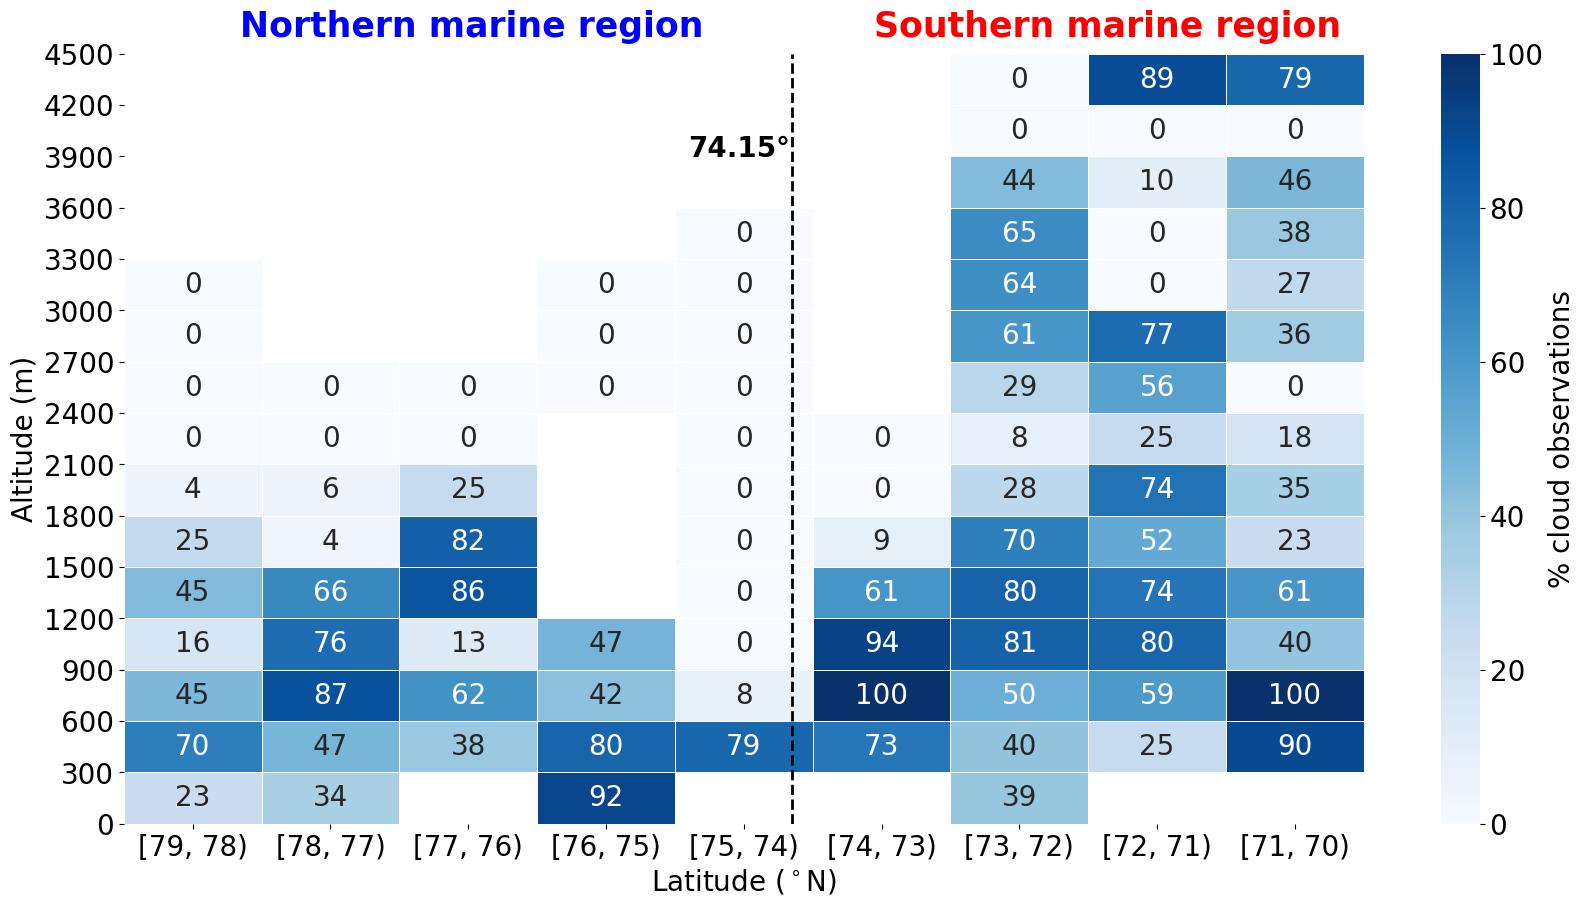

In [36]:
# heatplot of percentage of observations that where in-cloud
f, ax = plt.subplots(figsize=(20, 10))

#plot text size options
hs=25
ss=20

pl = sns.heatmap(dist_df, annot=True, fmt=".0f", cmap='Blues', ax=ax, 
            cbar_kws={"label": "% cloud observations"},
            linewidths=0.5, annot_kws={'size':ss}, vmin=0)

pl.set_xlabel('Latitude ($^\circ$N)',fontsize=ss)
pl.set_ylabel('Altitude (m)', fontsize=ss)
pl.axes.get_yaxis().set_visible(False) # only show x-axis, the other plot shows the y-axis

# colorbar options
cbar = pl.collections[0].colorbar  # Get the colorbar from the heatmap
cbar.ax.tick_params(labelsize=ss)  # Change the size of the colorbar ticks
cbar.set_label('% cloud observations', fontsize=ss)  # Change colorbar label size

# ticklabel adjustments
xlab = pl.get_xticklabels() 
pl.set_xticklabels(labels = xlab, size=ss)
ylab = pl.get_yticklabels()
for label in ylab:
    label.set_text(label.get_text().replace('.0', '')) # remove all '.0'
pl.set_yticklabels(labels = ylab, size = ss, rotation=45)

# add overlines
# Create overlay plot
ax_lines = f.add_axes(ax.get_position(), frameon=False)
ax_lines.set_xlim(79,70)
ax_lines.set_ylim(0,4500)
yticks = np.linspace (0,4500,300)
ax_lines.set_yticks(altitude_bins)
ax_lines.axes.get_xaxis().set_visible(False) # only show the y-axis, the other plot shows the xaxis (this shows the altitudes better.)
ax_lines.set_ylabel('Altitude (m)', fontsize=ss)
ax_lines.tick_params(labelsize=ss)


# Plot the limit between the two regions
ax_lines.axvline(lat_bands[1], ls='--', c='k', lw=2)
ax_lines.text(lat_bands[1] + 4, 4600, 'Northern marine region', c='b', weight='bold', fontsize=hs)
ax_lines.text(lat_bands[1] - 0.6, 4600, 'Southern marine region', c='r', weight='bold', fontsize=hs)
ax_lines.text(lat_bands[1] + 0.75, 3900, f"{lat_bands[1]:.2f}°", weight='bold',c='k', fontsize=ss)

#plt.title(f'Percentage of in cloud observations per total obs per alt_bin vs. lat_bin \n \
#            Preselection: {pre_text}\n \
#            in-cloud threshold method: {th_method}, threshold(s): {th}')
#plt.title(f'Percentage of in cloud observations \n per total obs per alt_bin vs. lat_bin', fontsize=20)
plt.savefig(save_path + f'Perc_incloud_alt_lat_{sample_rate}s_{th_method}{preopt}.png')

print(save_path + f'Perc_incloud_alt_lat_{sample_rate}s_{th_method}{preopt}.png')

In [37]:
# --- Prep-work for other plots

# Select variables to plot
sel_vars = ['TWC','IWC100', 'LWC corr','SLF', 'region', 'altitude_bin', 'T']

# creating dataframes for easier reuse of plots
north_df = north_ds[sel_vars].to_dataframe().reset_index()
south_df = south_ds[sel_vars].to_dataframe().reset_index()

In [38]:
north_df

,time,TWC,IWC100,LWC corr,SLF,region,altitude_bin,T,lat,lon,alt,islasid
0,2022-03-24 10:46:19,0.012525,0.012525,0.000000,0.000000,north,1950,-26.590273,76.623123,10.949945,1907.660645,IS22-03
1,2022-03-24 10:46:24,0.016921,0.001204,0.015717,92.885555,north,1950,-26.739100,76.627525,10.948870,1872.512329,IS22-03
2,2022-03-24 10:46:34,0.020467,0.020467,0.000000,0.000000,north,1950,-26.164263,76.636185,10.946351,1806.355469,IS22-03
3,2022-03-24 10:46:39,0.040621,0.040058,0.000562,1.384636,north,1650,-26.329687,76.640457,10.944839,1774.402222,IS22-03
4,2022-03-24 10:46:44,0.033571,0.033341,0.000231,0.686784,north,1650,-25.975134,76.644699,10.943193,1743.194946,IS22-03
...,...,...,...,...,...,...,...,...,...,...,...,...
2030,2022-04-03 14:55:24,0.066924,0.017177,0.049748,74.334156,north,450,-14.104056,75.013664,20.891901,327.928406,IS22-11
2031,2022-04-03 14:55:29,0.164068,0.003912,0.160156,97.615749,north,450,-14.258933,75.009193,20.890942,365.823456,IS22-11
2032,2022-04-03 14:55:34,0.109783,0.000297,0.109486,99.729196,north,450,-13.956264,75.004837,20.889999,406.250519,IS22-11
2033,2022-04-03 14:56:34,0.011005,0.010991,0.000014,0.126273,north,750,-13.114065,74.956543,20.880962,812.713684,IS22-11


In [39]:
# Create dataframe for visualizing available observations with Heatmap
# - number of observations per altitude bin vs SLF bin

def create_counts_slf(df, bin_labels, vert_param, Tbin = 2, norm=True):
    # Function to create counts array of the slf-data against either temperature or altitude
    # To use when making heatmaps. Keeps control of normalizations etc.
    # Input: 
    # --- df: dataframe with all data
    # --- bins_labels: total altitude bins (calculated earlier, not needed if temperature is used)
    # --- Vert_param: the vertical parameter to do he calculations on. either 'alt' or'T'
    # --- Tbin: degrees to bin temperature in
    # --- norm = True: if normalization per vertical layer should be done.
    # output:
    # --- count_df: df of number of observations per SLF bin and altitude bin/temperature bin for the given dataset
    
    # Calculate SLF bins:
    slf_bins = np.arange(0,105, 5) # slf_bins: create a set of 20 bins from 0 to 100% 
    df['SLF_bins'] = pd.cut(df['SLF'], bins=slf_bins, right=True, include_lowest=True) # bin the SLF data

    # calculate grouped data for the given vert_param
    if vert_param =='alt':
        grouped_data = df.groupby(['SLF_bins', 'altitude_bin'], observed = True).size() # group by both binning variables
        # Adjustments
        count_df = grouped_data.reset_index(name='counts') # convert to dataframe
        count_df = count_df.pivot(index='altitude_bin', columns='SLF_bins', values='counts')#.fillna(0) #pivot to get SLF on corrext axis
        count_df = count_df.reindex(bin_labels) # reindex to make sure all altitude_bins are included
        count_df = count_df.iloc[::-1] # reverse altitude order
    elif vert_param =='T':
        T_bins = np.arange(-35,-5,Tbin) # T_bins: from -35 to -5 in degre bins given (default 2)
        df['T_bins'] = pd.cut(df['T'], bins=T_bins, right=True, include_lowest=True) # bin the T data
        grouped_data = df.groupby(['SLF_bins', 'T_bins'], observed = True).size() # group by both binning variables
        # Adjustments
        count_df = grouped_data.reset_index(name='counts') # convert to dataframe
        count_df = count_df.pivot(index='T_bins', columns='SLF_bins', values='counts')#.fillna(0) #pivot to get SLF on corrext axis
        count_df = count_df.reindex(T_bins) # reindex to make sure all altitude_bins are included
   

    # normalize by altitude if chosen
    if norm: 
        print('Normalize!')
        sum_alt = count_df.sum(axis=1)
        normalized_count_df = count_df.div(sum_alt, axis=0)*100
        return normalized_count_df, count_df
    else:
        print('no normalization ...')
        # Return counts as integers
        return count_df
    

nnormcount_df, ncount_df = create_counts_slf(north_df, bin_labels, 'alt')
snormcount_df, scount_df = create_counts_slf(south_df, bin_labels, 'alt')


Normalize!
Normalize!


Normalize!
Normalize!


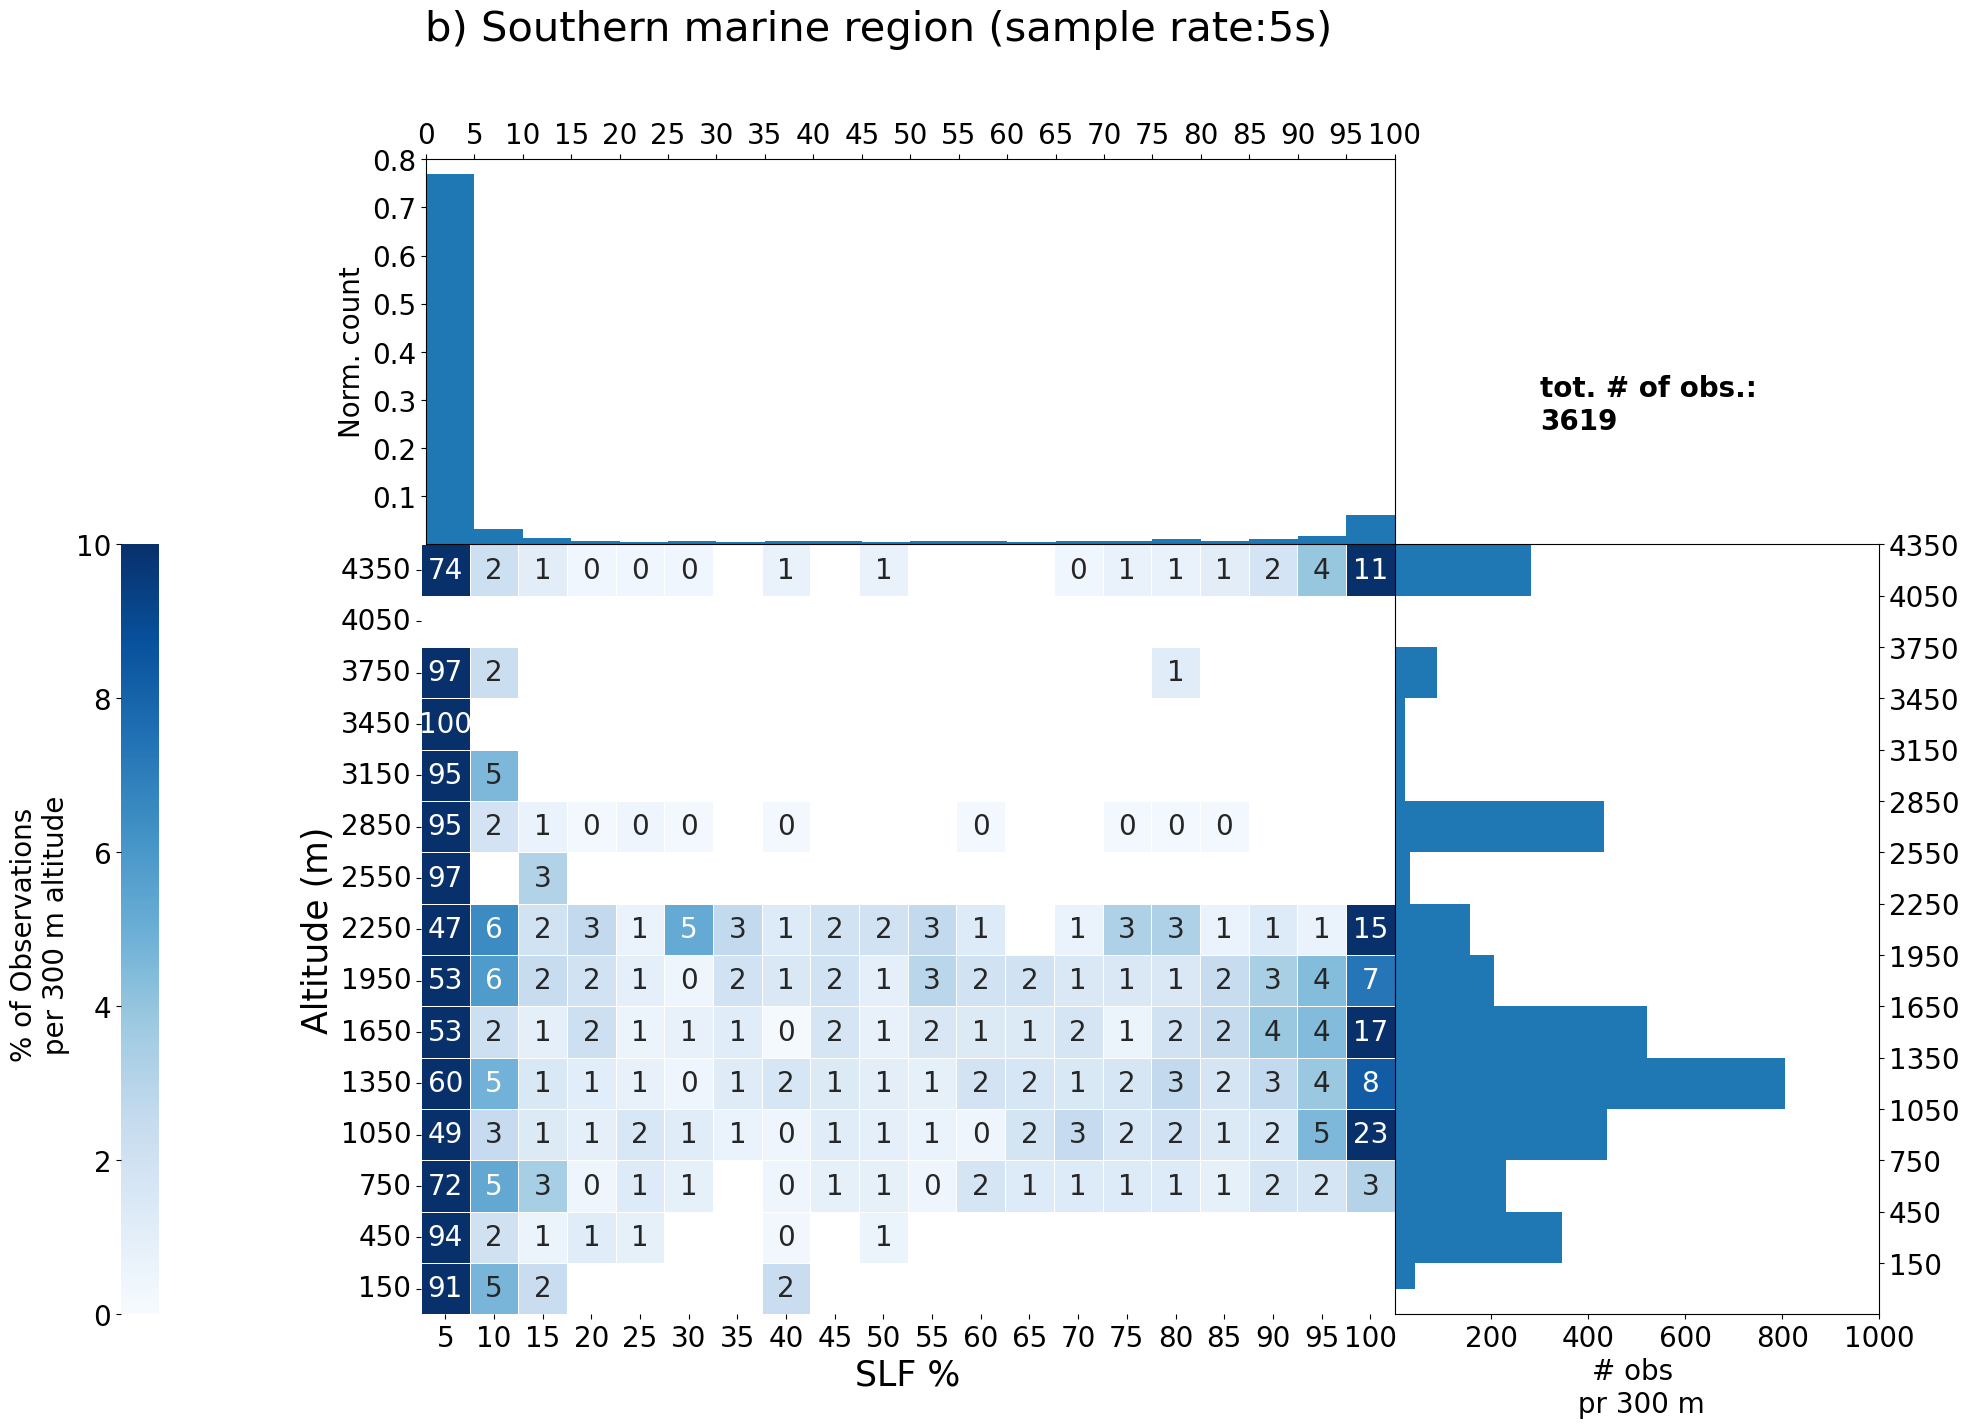

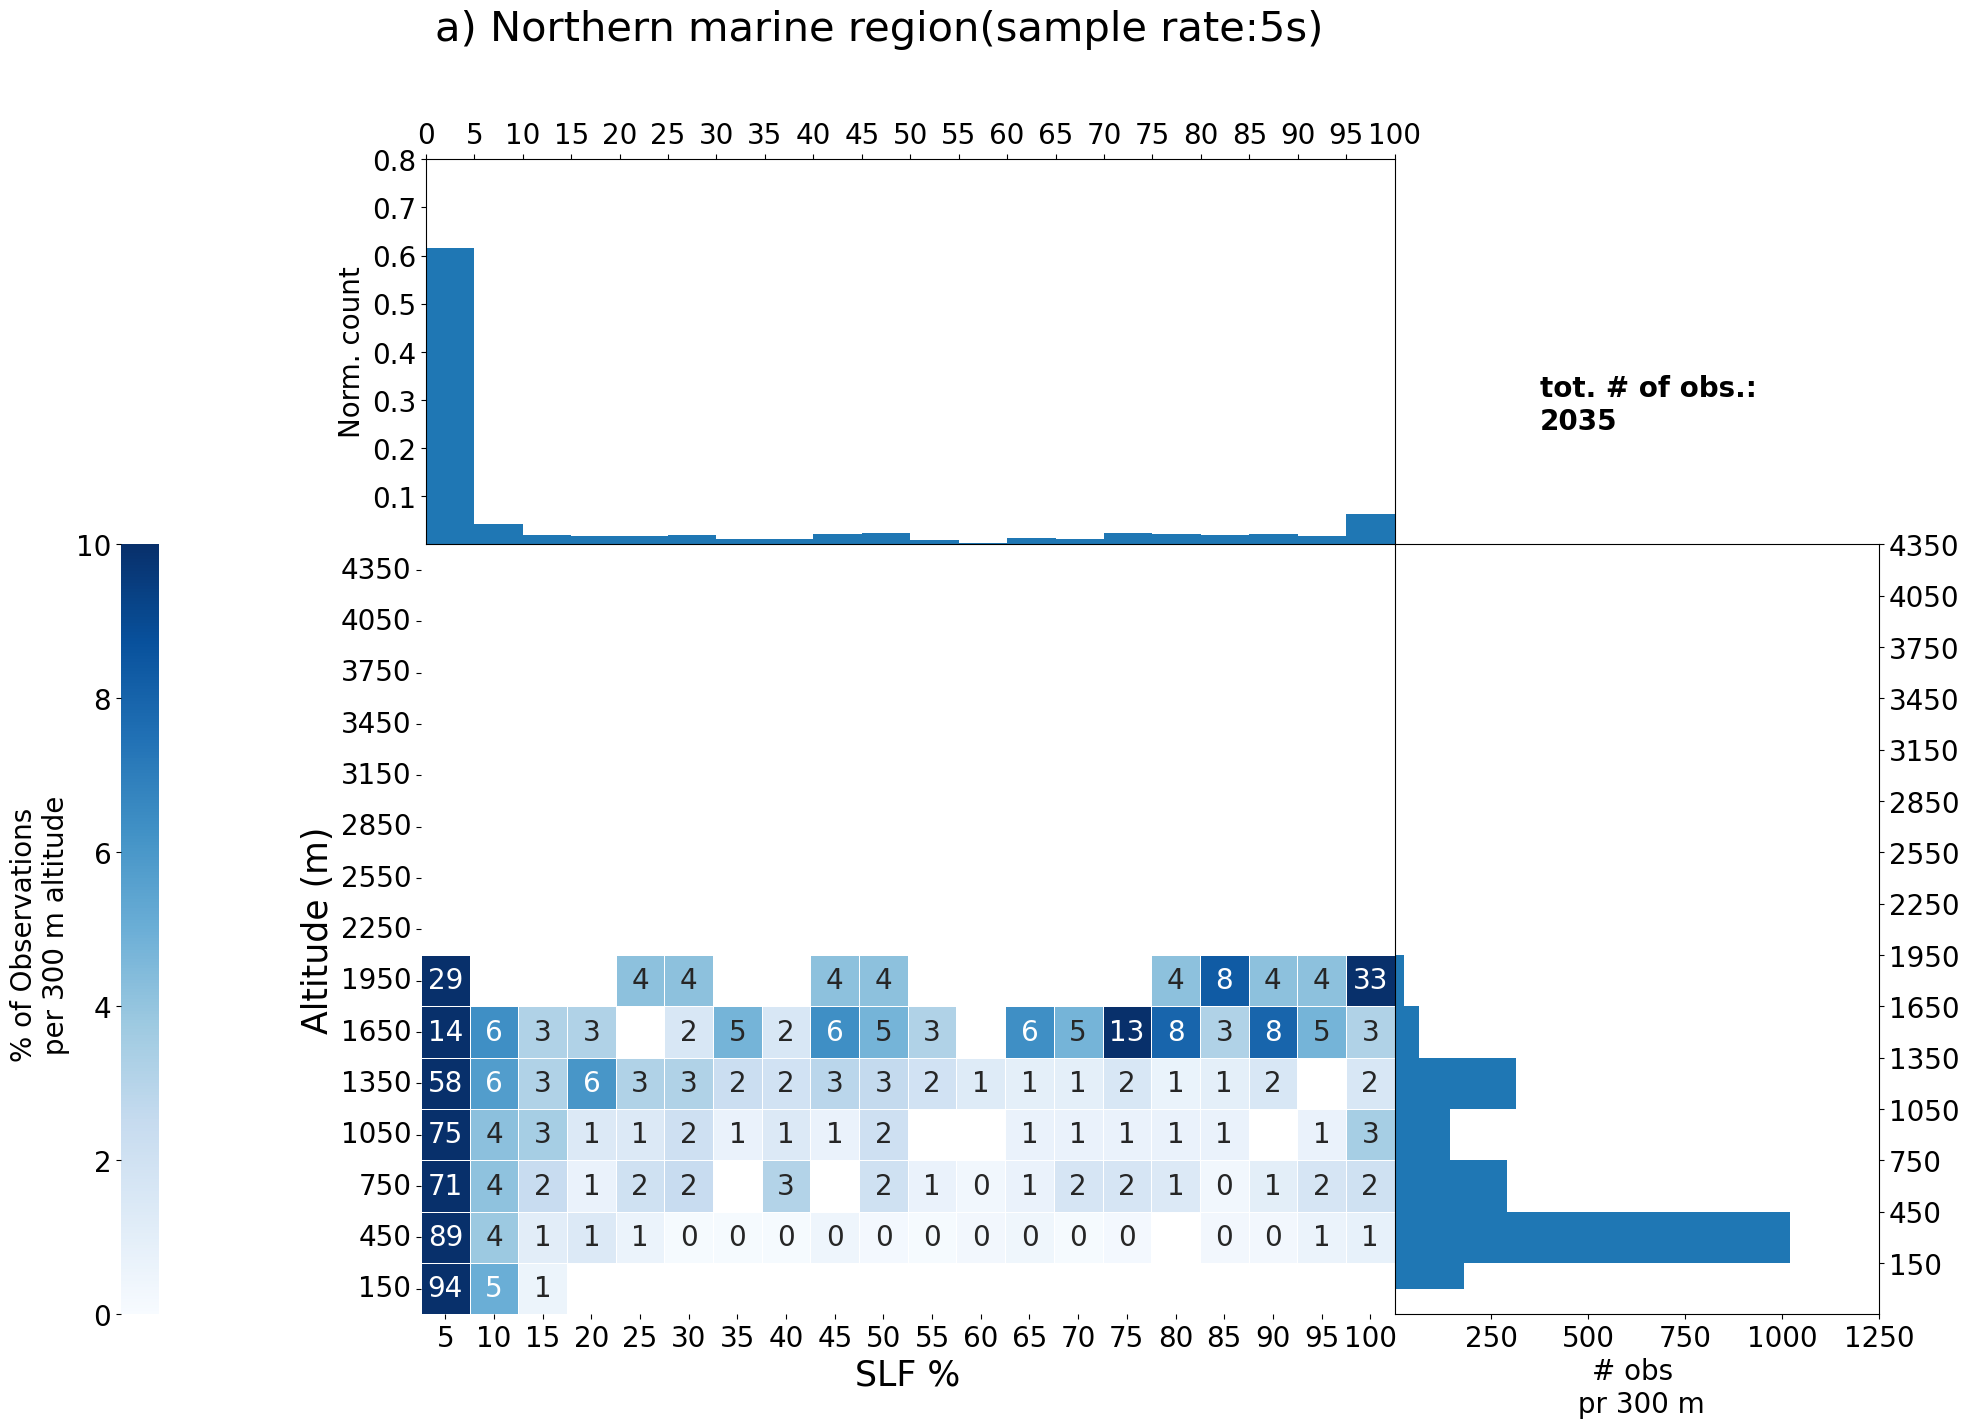

In [40]:
## SINGLE MARGPLOT ALTITUDE Code that works

def slf_marg_plot_alt(df, title, altitude_bins,bin_labels, x_bins=20, y_bins=None, x_range=[0, 100]):
    import matplotlib.gridspec as gridspec
    import numpy as np

    #plot text size options
    hs=25
    ss=20
    
    if y_bins is None:
        y_bins = len(altitude_bins) - 1  # number of bins, altitude bins contains edges
    
    # Prepare altitude bin edges based on altitude_bins
    if len(altitude_bins) < 2:
        raise ValueError("altitude_bins must contain at least two edges.")

    # preparing for histogram and 2d histogram
    # create a count_df for heatmap plot
    norm_count_df, count_df = create_counts_slf(df, bin_labels, 'alt')
  
    vert_df = count_df.sum(axis=1)
   
    fig = plt.figure(figsize=(25,15))
    
    gs = gridspec.GridSpec(3, 4, wspace = 0, hspace = 0)
    ax_main = plt.subplot(gs[1:3, 0:3])
    ax_xDist = plt.subplot(gs[0, 1:3])#,sharex=ax_main)
    ax_yDist = plt.subplot(gs[1:3, 3])#,sharey=ax_main)
    ax_text = plt.subplot(gs[0,3])
    ax_text.axis('off')
    plots.letter_annotation(ax_text, 0.3, 0.3, f'tot. # of obs.: \n{len(df)}', size=ss)

    hh = sns.heatmap(norm_count_df, cmap='Blues', ax=ax_main, annot=True, fmt=".0f", annot_kws={"fontsize":ss},
            cbar_kws={"label": "% of Observations","location":"left","pad":0.18}, vmin=0, vmax=10,
            linewidths=0.5)
    
    ax_main.set_ylabel('Altitude (m)', fontsize = hs)
    ax_main.set_xlabel('SLF %', fontsize = hs)
    xlabel = [interval.right for interval in norm_count_df.sum(axis=0).index] # get the highest number from the interval
    xlabel = [int(num) for num in xlabel] # turn into int
    ax_main.set_xticklabels(xlabel)
    ax_main.tick_params('x',rotation=0)

    #colorbar adjustments:
    cbar = ax_main.collections[0].colorbar
    cbar.ax.tick_params(labelsize=ss) #change label textsize
    cbar.set_label(label = "% of Observations \n per 300 m altitude", fontsize=ss)

    # Marginal histograms
    # set the horizontal histogram
    horiz = norm_count_df.sum(axis=0)
    bin_edges = [interval.left for interval in horiz.index] + [horiz.index[-1].right]
    # normalize the horiz values
    horiz_sum = horiz.sum()
    norm_horiz = horiz/horiz_sum
    heights = norm_horiz.values.tolist()  # Get the values as a list

    ax_xDist.hist(bin_edges[:-1],bins = bin_edges, weights= heights)
    ax_xDist.set_ylabel('Norm. count', fontsize = ss)
    ax_xDist.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
    ax_xDist.set_xlim(0,100)
    ax_xDist.set_ylim(0,0.8)
    ax_xDist.set_xticks([0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100])
    ax_xDist.set_yticks([tick for tick in ax_xDist.get_yticks() if tick != 0])
    ax_xDist.tick_params(axis='both', which='major', labelsize=ss)
    ax_xDist.tick_params(axis='both', which='minor', labelsize=ss)

    # set the vertical histogram
    vert = count_df.sum(axis=1)
    vert.sort_index(inplace=True)
    bin_edges = [0] + vert.index.tolist()
    heights = vert.values.tolist()  # Get the values as a list
    
    ax_yDist.hist(bin_edges[:-1],bins = bin_edges, weights= heights, orientation='horizontal')
    ax_yDist.set_xlabel('# obs \n pr 300 m', fontsize = ss)
    ax_yDist.yaxis.tick_right()
    ax_yDist.set_ylim(-150,4350) # if alt
    #ax_yDist.set_ylim(-5,-35) # if T
    ax_yDist.set_yticks(bin_edges[1:])
    ax_yDist.tick_params(axis='both', which='major', labelsize=ss)
    ax_yDist.tick_params(axis='both', which='minor', labelsize=ss)
    ax_yDist.set_xticks([tick for tick in ax_yDist.get_xticks() if tick != 0])

    # ticklabel adjustments
    xlab = ax_main.get_xticklabels() 
    ax_main.set_xticklabels(labels = xlab, size=ss)
    ylab = ax_main.get_yticklabels()
    for label in ylab:
        label.set_text(label.get_text().replace('.0', '')) # remove all '.0'
    ax_main.set_yticklabels(labels = ylab, size = ss, rotation=0)
    
    plt.suptitle(title, fontsize = 30)
    
    return(fig)


s_plot = slf_marg_plot_alt(south_df, f'b) Southern marine region (sample rate:{sample_rate}s)', altitude_bins, bin_labels)
s_plot.savefig(save_path+f'SLF_alt_South_{sample_rate}s_{th_method}{preopt}.png') # Save to
n_plot = slf_marg_plot_alt(north_df, f'a) Northern marine region(sample rate:{sample_rate}s)', altitude_bins, bin_labels)
n_plot.savefig(save_path+f'SLF_alt_North_{sample_rate}s_{th_method}{preopt}.png') # Save to

In [41]:
norm_count_df, count_df = create_counts_slf(south_df, bin_labels, 'T')
test = count_df.sum(axis=1)
test

Normalize!


T_bins
-35      0.0
-33      0.0
-31      0.0
-29      0.0
-27      0.0
-25     32.0
-23    323.0
-21     64.0
-19    388.0
-17    676.0
-15    570.0
-13    641.0
-11    134.0
-9     347.0
-7     273.0
dtype: float64

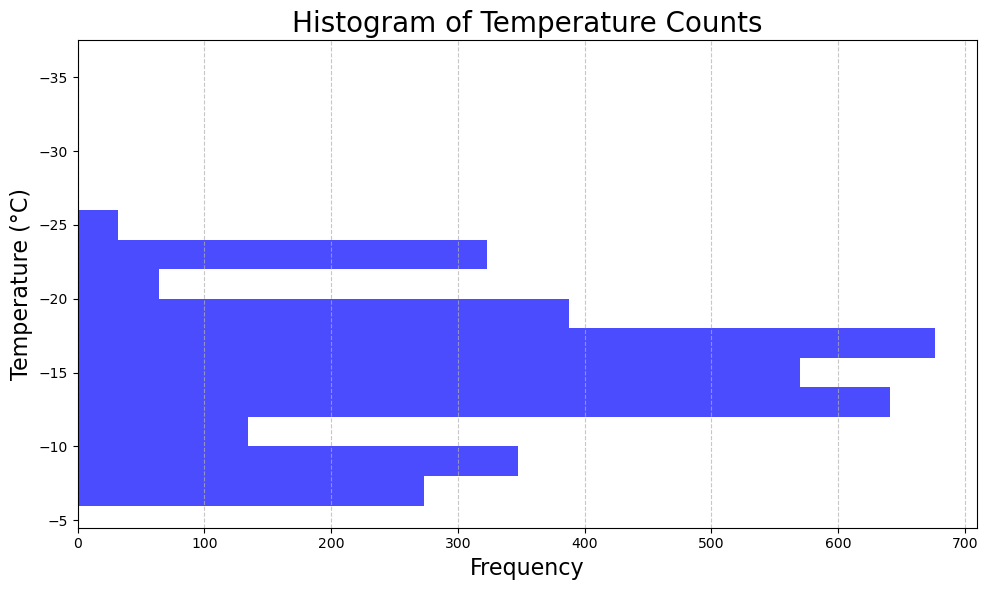

In [42]:
import matplotlib.pyplot as plt
import pandas as pd

# Sample data (as provided)
data = {
    -35: 0.0,
    -33: 0.0,
    -31: 0.0,
    -29: 0.0,
    -27: 0.0,
    -25: 32.0,
    -23: 323.0,
    -21: 64.0,
    -19: 388.0,
    -17: 676.0,
    -15: 570.0,
    -13: 641.0,
    -11: 134.0,
    -9: 347.0,
    -7: 273.0,
}

# Convert it to a Series (like the original data structure)
T_bins = pd.Series(data)

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(test.index, test.values, height=2, color='blue', alpha=0.7)  # Use barh for horizontal bar plot

# Customizing the plot
plt.title('Histogram of Temperature Counts', fontsize=20)
plt.ylabel('Temperature (°C)', fontsize=16)
plt.xlabel('Frequency', fontsize=16)
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Invert the y-axis so -35 is at the top
plt.gca().invert_yaxis()

plt.tight_layout()

# Show the plot
plt.show()


Normalize!
Normalize!


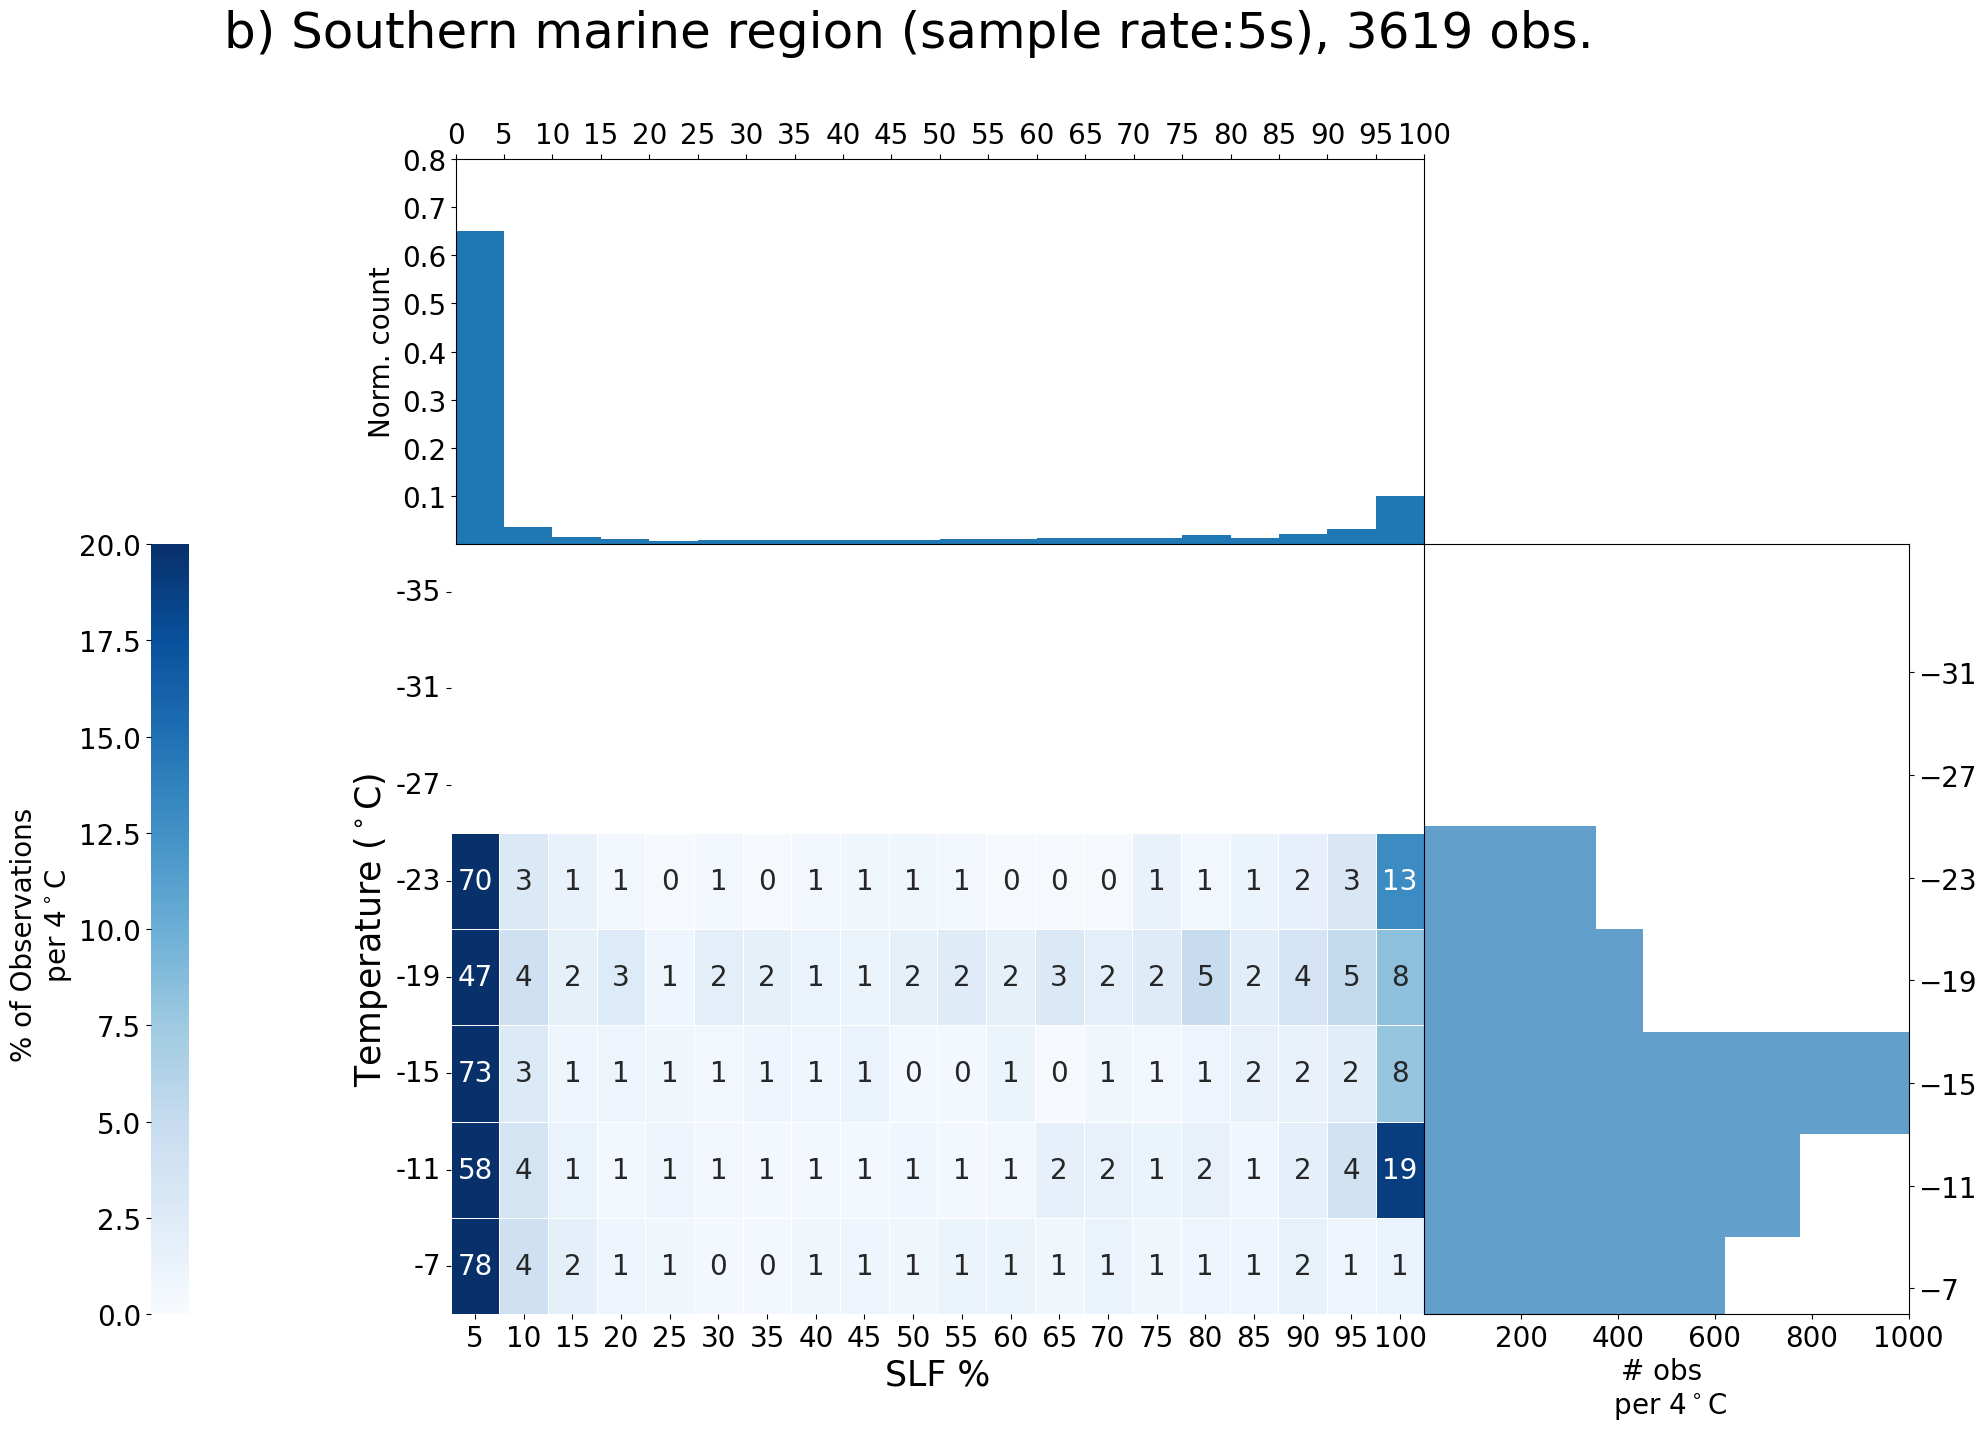

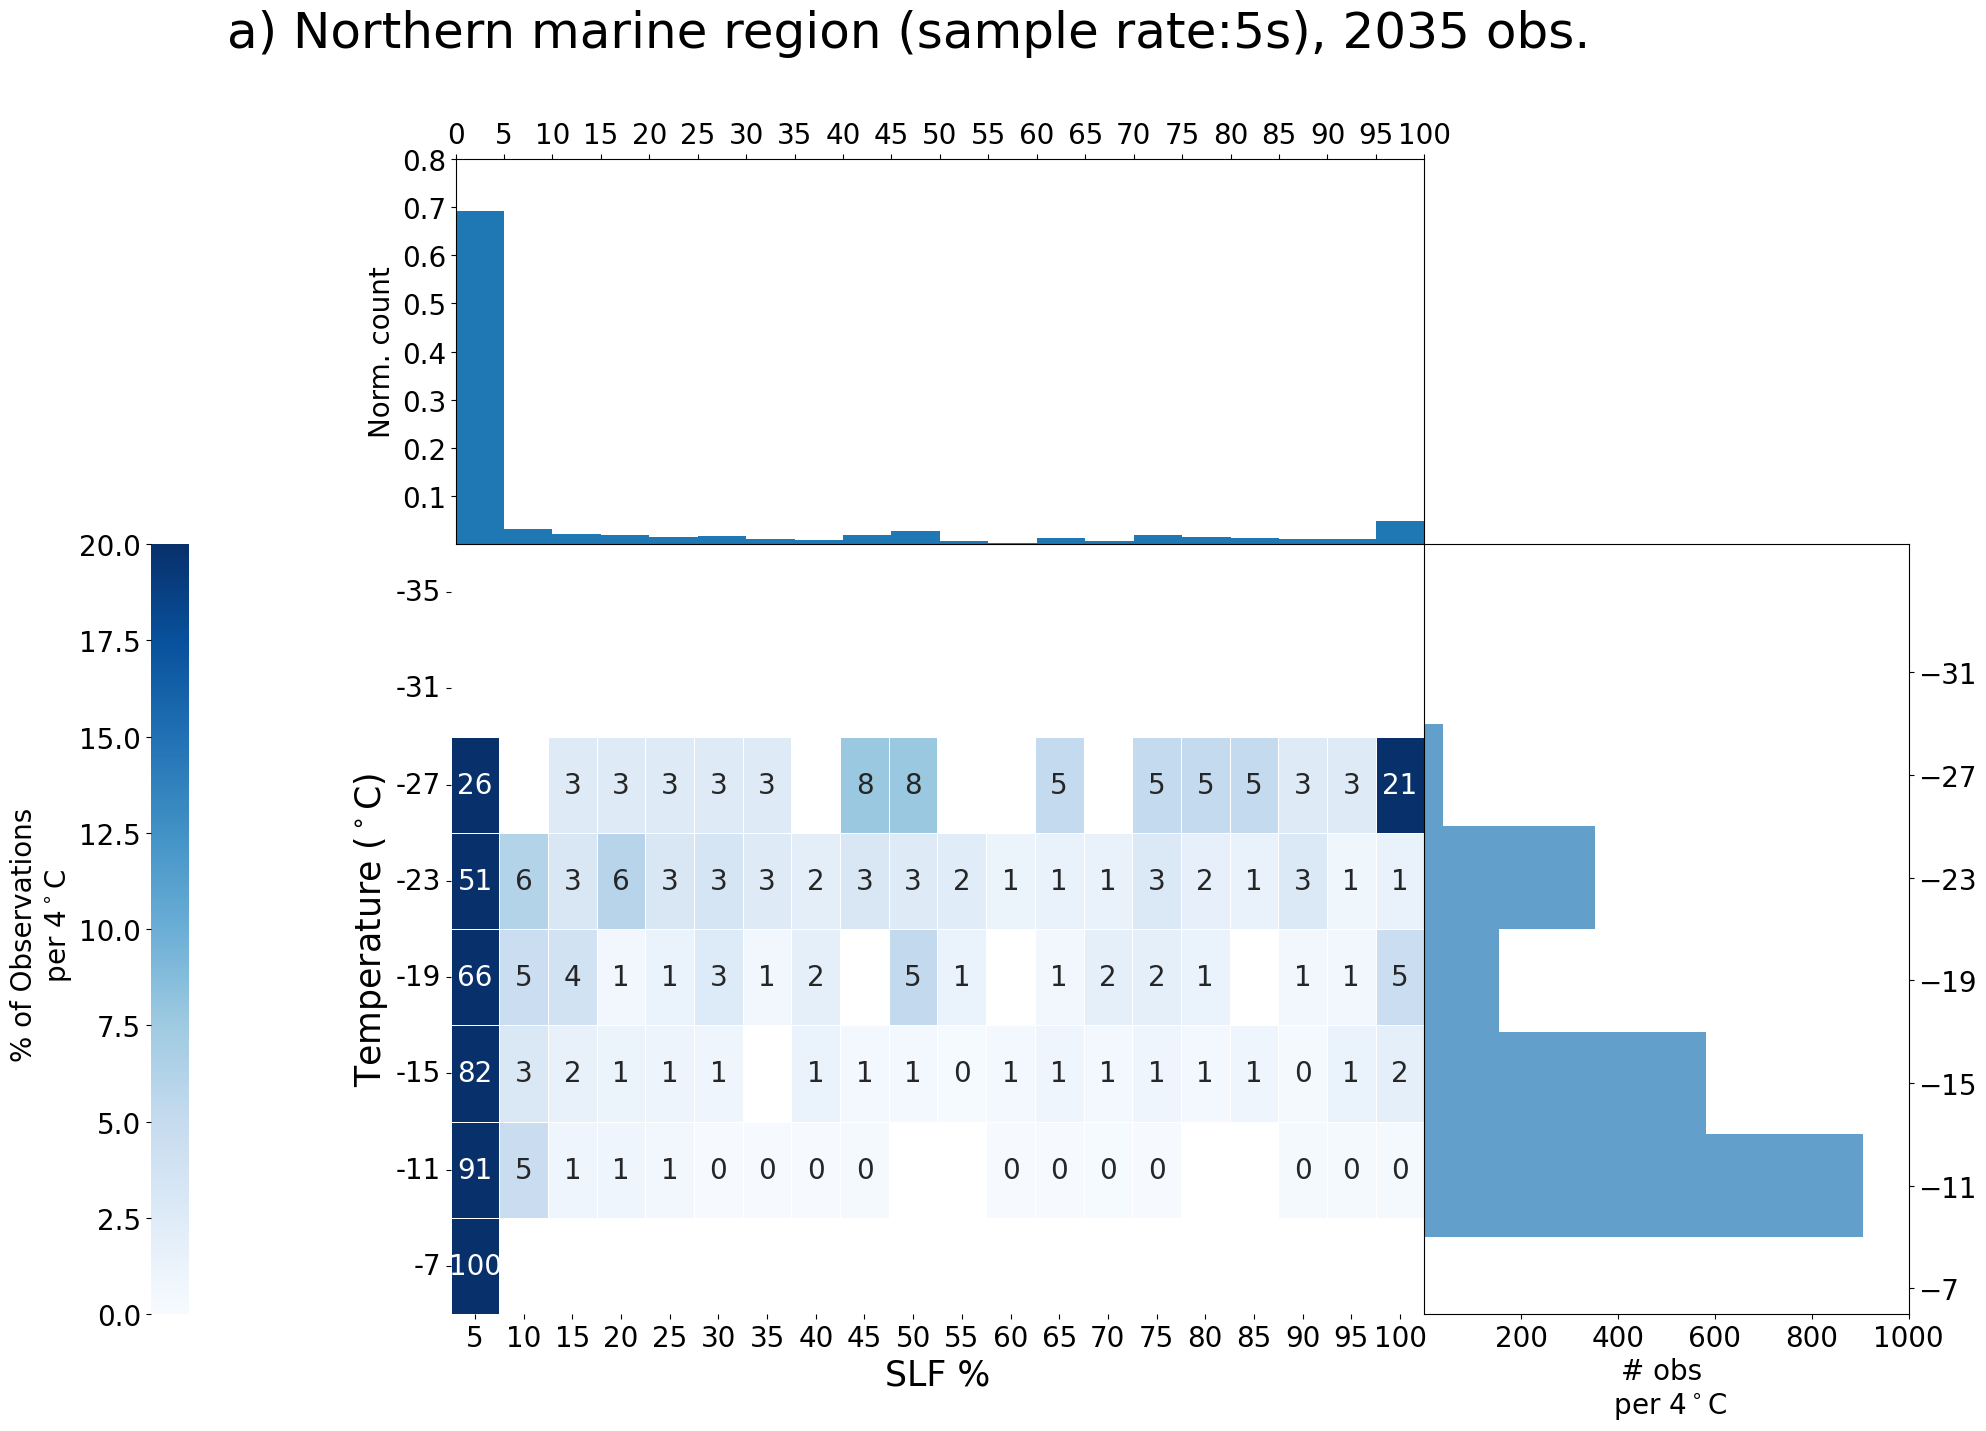

In [43]:
## SINGLE MARGPLOT Temperature testing

def slf_marg_plot_alt(norm_count_df, count_df,df, title, altitude_bins, max_obs, bin_labels, x_bins=20, y_bins=None, x_range=[0, 100]):
    import matplotlib.gridspec as gridspec
    import numpy as np

    #plot text size options
    hs=25
    ss=20
    
    if y_bins is None:
        y_bins = len(altitude_bins) - 1  # number of bins, altitude bins contains edges
    
    # Prepare altitude bin edges based on altitude_bins
    if len(altitude_bins) < 2:
        raise ValueError("altitude_bins must contain at least two edges.")
  
    vert_df = count_df.sum(axis=1)
   
    fig = plt.figure(figsize=(25,15))
    
    gs = gridspec.GridSpec(3, 4, wspace = 0, hspace = 0)
    ax_main = plt.subplot(gs[1:3, 0:3])
    ax_xDist = plt.subplot(gs[0, 1:3])#,sharex=ax_main)
    ax_yDist = plt.subplot(gs[1:3, 3])#,sharey=ax_main)
    ax_text = plt.subplot(gs[0,3])
    ax_text.axis('off')
    #plots.letter_annotation(ax_text, 0.3, 0.3, f'tot. # of obs.: \n{len(df)}', size=ss)

    hh = sns.heatmap(norm_count_df, cmap='Blues', ax=ax_main, annot=True, fmt=".0f", annot_kws={"fontsize":ss},
            cbar_kws={"label": "% of Observations","location":"left","pad":0.18}, vmin=0, vmax=20,
            linewidths=0.5)
    
    ax_main.set_ylabel('Temperature ($^\circ$C)', fontsize = hs)
    ax_main.set_xlabel('SLF %', fontsize = hs)
    xlabel = [interval.right for interval in norm_count_df.sum(axis=0).index] # get the highest number from the interval
    xlabel = [int(num) for num in xlabel] # turn into int
    ax_main.set_xticklabels(xlabel)
    ax_main.tick_params('x',rotation=0)

    #colorbar adjustments:
    cbar = ax_main.collections[0].colorbar
    cbar.ax.tick_params(labelsize=ss) #change label textsize
    cbar.set_label(label = f'% of Observations \n per {tbin}$^\circ$C', fontsize=ss)

    # Marginal histograms
    # set the horizontal histogram
    horiz = norm_count_df.sum(axis=0)
    bin_edges = [interval.left for interval in horiz.index] + [horiz.index[-1].right]
    # normalize the horiz values
    horiz_sum = horiz.sum()
    norm_horiz = horiz/horiz_sum
    heights = norm_horiz.values.tolist()  # Get the values as a list
    
    ax_xDist.hist(bin_edges[:-1],bins = bin_edges, weights= heights)
    ax_xDist.set_ylabel('Norm. count', fontsize = ss)
    ax_xDist.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
    ax_xDist.set_xlim(0,100)
    ax_xDist.set_ylim(0,0.8)
    ax_xDist.set_xticks([0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100])
    ax_xDist.set_yticks([tick for tick in ax_xDist.get_yticks() if tick != 0])
    ax_xDist.tick_params(axis='both', which='major', labelsize=ss)
    ax_xDist.tick_params(axis='both', which='minor', labelsize=ss)
    
    # set the vertical histogram
    vert = count_df.sum(axis=1) # number of observations per vertical bin (temp/alt)
    #print(vert)
    vert.sort_index(inplace=True)
    bin_edges = vert.index.tolist()
    heights = vert.values.tolist()  # Get the values as a list
     
    #ax_yDist.hist(bin_edges,bins = bin_edges, weights= heights, orientation='horizontal')
    ax_yDist.barh(vert.index, vert.values, height=4, alpha=0.7)
    ax_yDist.set_xlabel(f'# obs \n per {tbin}$^\circ$C', fontsize = ss)
    ax_yDist.yaxis.tick_right()
    #ax_yDist.set_ylim(-150,4350) # if alt
    ax_yDist.set_ylim(-6,-36) # if T
    ax_yDist.set_xlim(0,max_obs)
    ax_yDist.set_yticks(bin_edges[1:])
    ax_yDist.tick_params(axis='both', which='major', labelsize=ss)
    ax_yDist.tick_params(axis='both', which='minor', labelsize=ss)
    ax_yDist.set_xticks([tick for tick in ax_yDist.get_xticks() if tick != 0])
    
    # ticklabel adjustments
    xlab = ax_main.get_xticklabels() 
    ax_main.set_xticklabels(labels = xlab, size=ss)
    ylab = ax_main.get_yticklabels()
    for label in ylab:
        label.set_text(label.get_text().replace('.0', '')) # remove all '.0'
    ax_main.set_yticklabels(labels = ylab, size = ss, rotation=0)
    
    plt.suptitle(title + f', {len(df)} obs.', fontsize = 36)
    
    return fig

# preparing for histogram and 2d histogram
# create a count_df for heatmap plot
tbin = 4 # temperature bin size
    
#Make counts for both regions:
s_norm_count_df, s_count_df = create_counts_slf(south_df, bin_labels, 'T', Tbin=tbin)
n_norm_count_df, n_count_df = create_counts_slf(north_df, bin_labels, 'T', Tbin=tbin)

#find highest number of observations per temperaturebin for the two regions (to use as xlim)
max_obs = round(max([s_count_df.sum(1).max(),s_count_df.sum(1).max()]),-3)


s_plot = slf_marg_plot_alt(s_norm_count_df, s_count_df,south_df, f'b) Southern marine region (sample rate:{sample_rate}s)', altitude_bins,max_obs, bin_labels)
s_plot.savefig(save_path+f'SLF_T_South_{sample_rate}s_{th_method}{preopt}.png') # Save to
n_plot = slf_marg_plot_alt(n_norm_count_df, n_count_df,north_df, f'a) Northern marine region (sample rate:{sample_rate}s)', altitude_bins,max_obs, bin_labels)
n_plot.savefig(save_path+f'SLF_T_North_{sample_rate}s_{th_method}{preopt}.png') # Save to


FileNotFoundError: [Errno 2] No such file or directory: 'Latitudebands/EGU/LWC_IWC_th/LWC_IWC_TWC_per_lat_region_LWC_IWC_th.png'

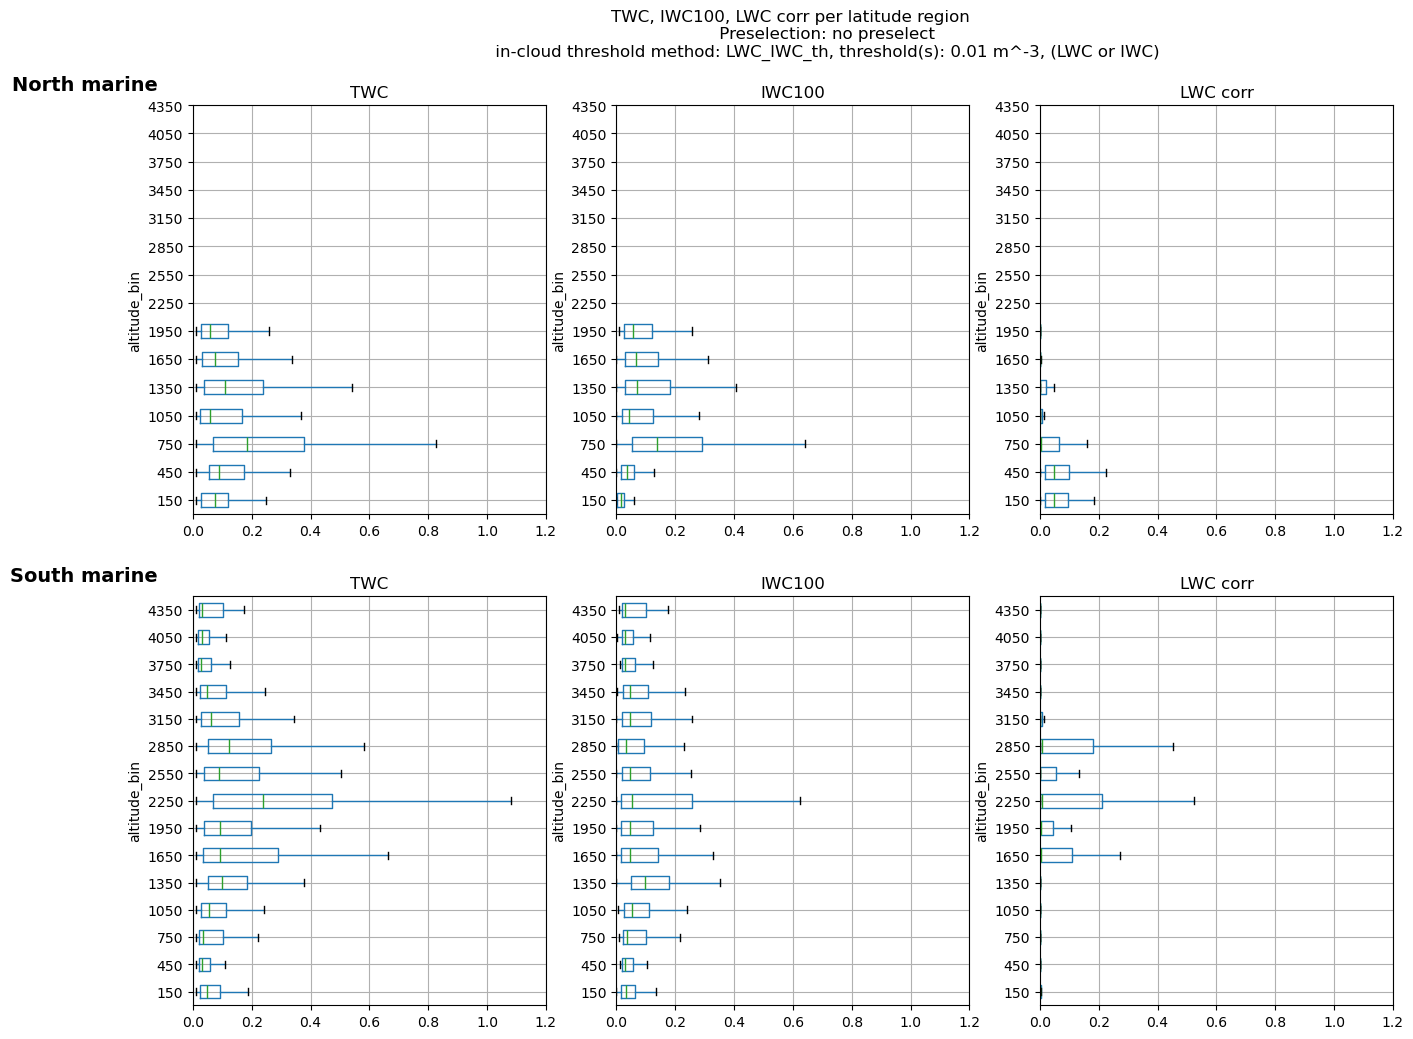

In [59]:
# -- BOXPLOT: Water content, original

# Define the dataframes and columns
row_titles = ['North marine','South marine']
dfs = [north_df, south_df]
var = ['TWC', 'IWC100','LWC corr']

# Get list of all available altitude categories in the full dataset
alt_cats = np.unique(ds_incloud['altitude_bin'].values)

# subplotsize
n_rows = len(var)

fig, ax = plt.subplots(2, n_rows, figsize=(15, 12))


# Plot the data and add the count of observations
for col, df in enumerate(dfs):
    alt_bins = df['altitude_bin'].unique()
    positions = [np.where(alt_cats == alt)[0][0] + 1 for alt in alt_bins]
    for row, v in enumerate(var):
        df.boxplot(column= v, by='altitude_bin', ax=ax[col, row], positions=positions, vert=False, showfliers=False)
        ax[col, row].set_yticks(range(1, len(alt_cats) + 1))
        ax[col, row].set_yticklabels(alt_cats)

        if col == len(var) - 1:
            # Add counts only to the last plot
            counts = df['altitude_bin'].value_counts() #get the number of observations per altitude bin
            for group, count in counts.items():
                # for each item in the counts per altitude bin:
                # 1: find out where it is located in the array of sorted altitude bins
                # 2: plot the count as text by the boxplot located at this location.
                index_of_group = np.where(alt_cats==group)[0] +1  # change from 0 base to 1 base
                ax[row,0].text(1, index_of_group, f'n={count}', verticalalignment='center', fontsize=8, color='blue')
           

# Set titles for each row
for i, title in enumerate(row_titles):
    ax[i, 0].text(-0.1, 1.05, title, transform=ax[i, 0].transAxes, fontsize=14, fontweight='bold', va='center', ha='right')

# Adjust layout
plt.setp(ax, xlim=(0, 1.2))
#plt.setp(ax, xlim=(0, 3.5)) # lims for showfliers = True


# --- Figure 
plt.suptitle(f'{', '.join(str(e) for e in var)} per latitude region \n \
            Preselection: {pre_text}\n \
            in-cloud threshold method: {th_method}, threshold(s): {th}') # title
plt.savefig(save_path+f'{th_method}/LWC_IWC_TWC_per_lat_region_{th_method}{preopt}.png') # Save to
plt.show()


In [ ]:
ds_incloud['T'].attrs

ValueError: Could not interpret value `SLF_all` for `x`. An entry with this name does not appear in `data`.

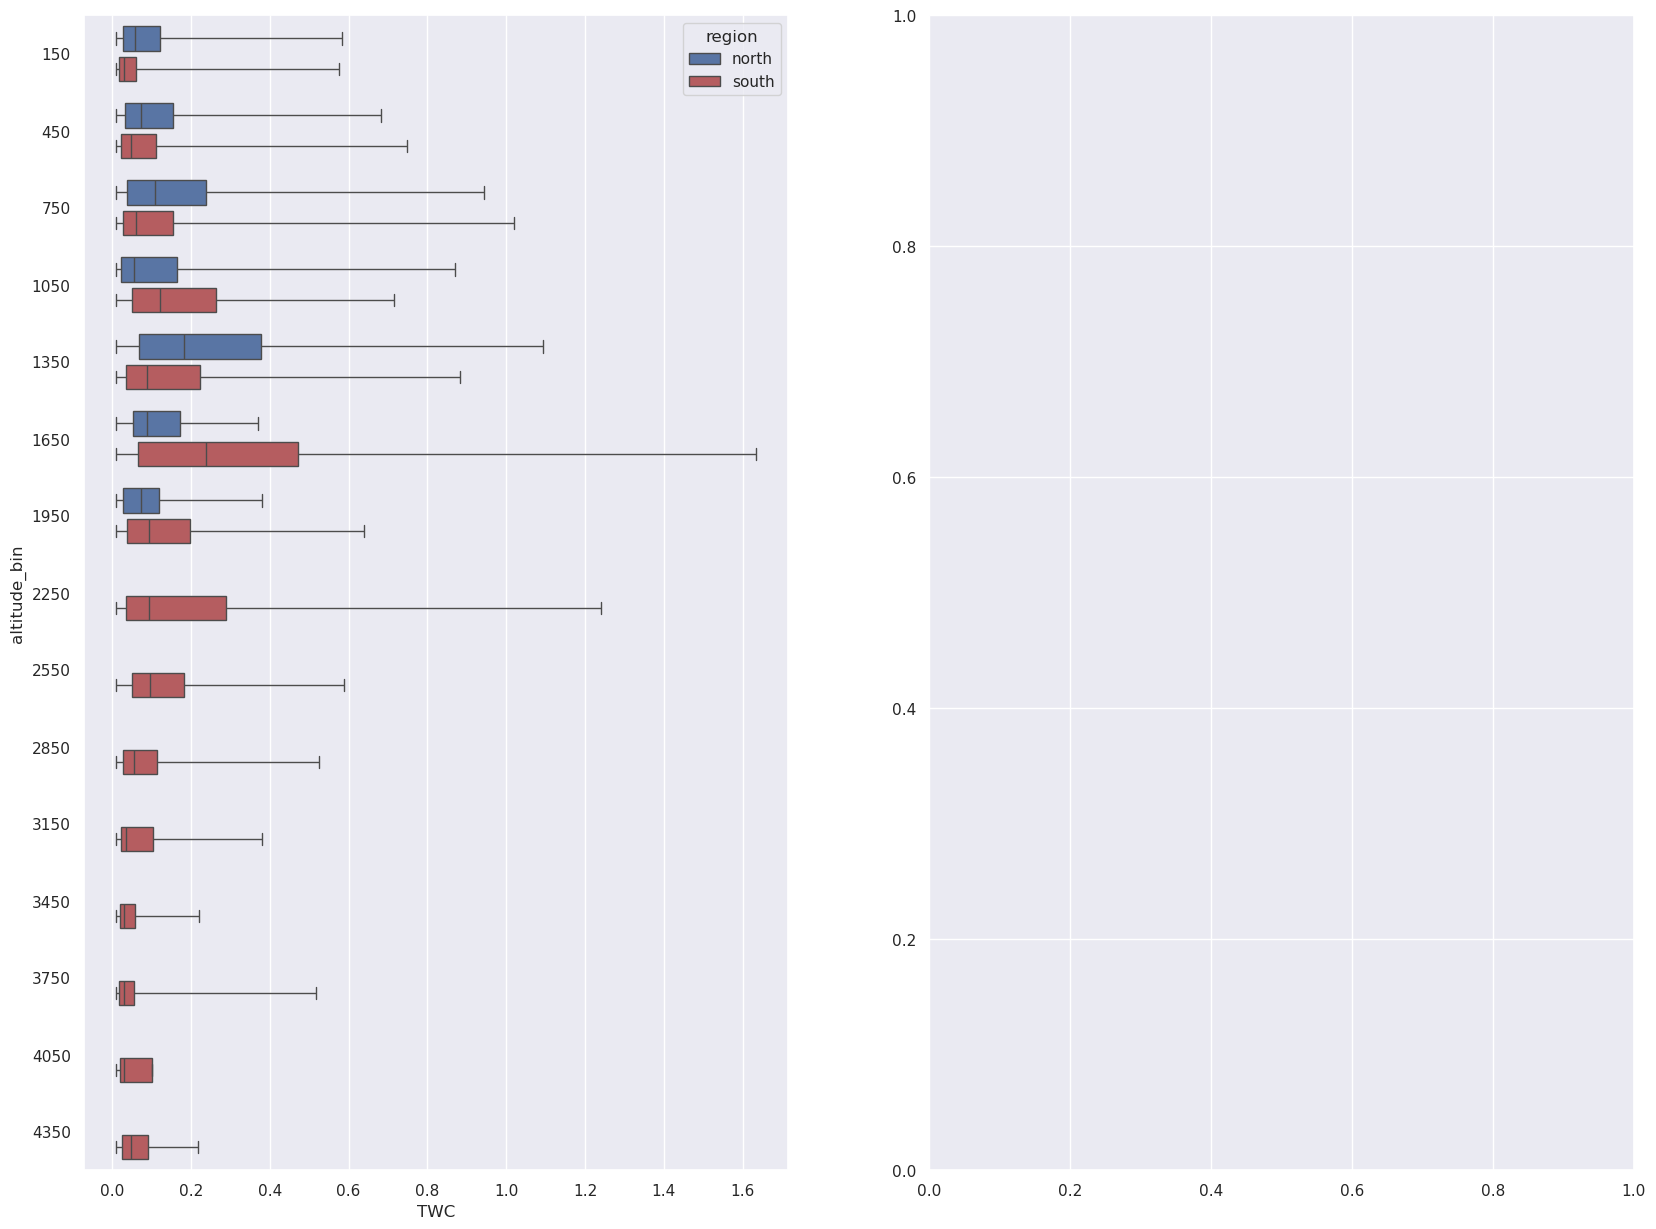

In [60]:
# -- BOXPLOT: Total water content and SLF


import seaborn as sns

sns.set_theme(style='darkgrid')

fig, ax = plt.subplots(1,2, figsize=(20, 15))

twc_p = sns.boxplot(data= ds_incloud, y ='altitude_bin', x='TWC', hue='region', whis=(0,99), gap=.2,
            palette=dict(north='b', south='r'), 
            width=0.8, orient = 'h', ax=ax[0],
           showfliers=False)
slf_p = sns.boxplot(data= ds_incloud, y ='altitude_bin', x='SLF_all', hue='region', whis=(0,99), gap=.2, 
            palette=dict(north='b', south='r'), 
            width=0.8, orient = 'h', ax=ax[1],
           showfliers=False)

for a in ax:
    a.set_ylim(reversed(a.get_ylim()))  # Reversing the y-axis for each subplot

twc_p.set(xlabel=f"Total Water Content ({ds_incloud['TWC'].attrs['unit']})", ylabel="Altitude bins (pr 300 m)")
slf_p.set(xlabel=f"Supercooled Liquid Fraction, LWC/TWC (%)", ylabel="Altitude bins (pr 300 m)")
#plt.setp(ax, xlim=(-0.01, 3.5))  

# --- Figure 
plt.suptitle(f'Vertical distributions of TWC and SLF divided by latitude region \n \
            Preselection: {pre_text}\n \
            in-cloud threshold method: {th_method}, threshold(s): {th}') # title
plt.savefig(save_path+f'{th_method}/WITHOUT_OUTLIERS_seaborn_WC_per_Latitude_region_{th_method}{preopt}.png') # Save to
plt.show()

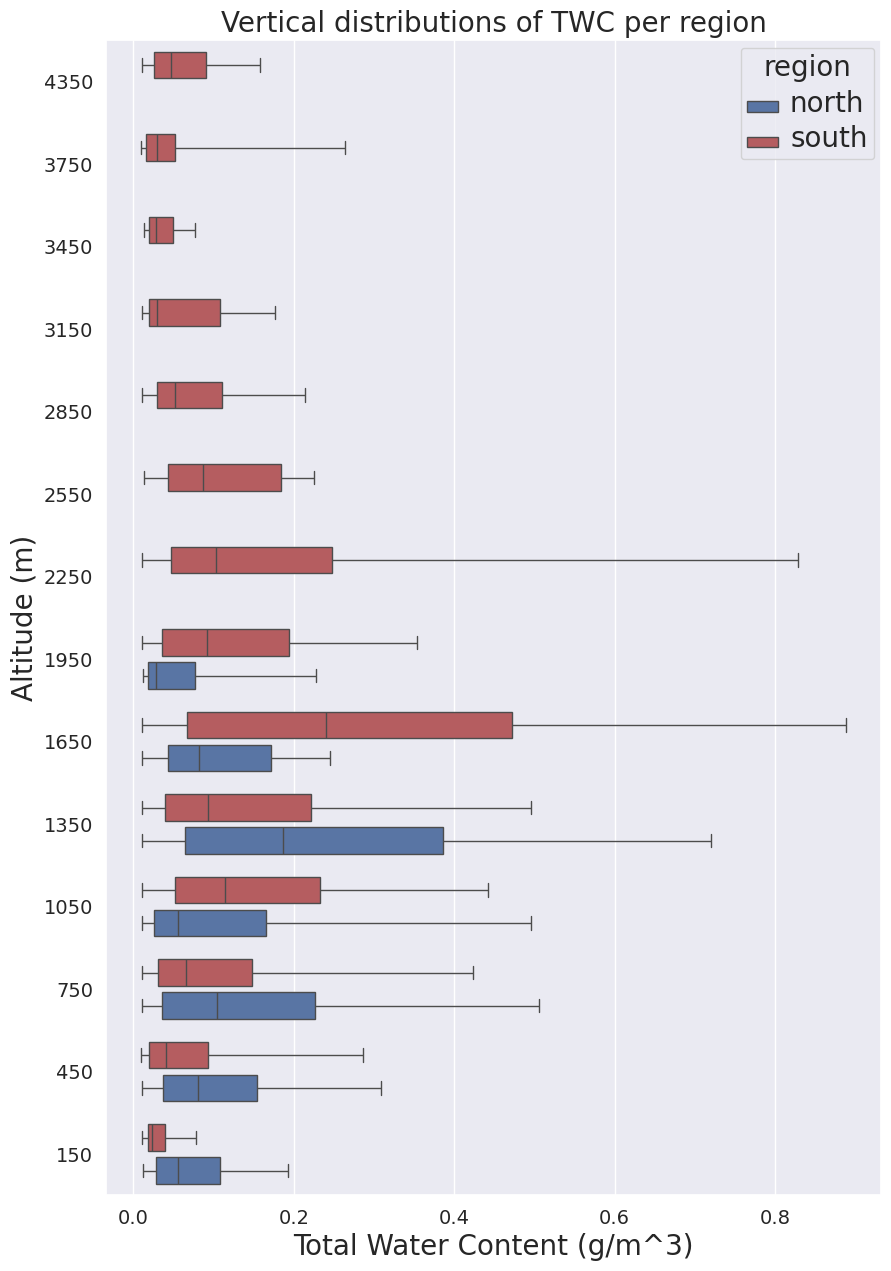

In [24]:
# -- BOXPLOT: Total water content
import seaborn as sns

sns.set_theme(style='darkgrid')

fig, ax = plt.subplots(figsize=(10, 15))

twc_p = sns.boxplot(data = ds_incloud, y ='altitude_bin', x='TWC', hue='region', whis=(0,95), gap=.2,
            palette=dict(north='b', south='r'), 
            width=0.8, orient = 'h', ax=ax,
           showfliers=False)

ax.set_ylim(reversed(twc_p.get_ylim()))  # Reversing the y-axis for each subplot

# titles and adjust fontzises
twc_p.axes.set_title(f'Vertical distributions of TWC per region',fontsize=20)
twc_p.set_xlabel(f"Total Water Content ({ds_incloud['TWC'].attrs['unit']})",fontsize=20)
twc_p.set_ylabel("Altitude (m)",fontsize=20)
twc_p.tick_params(labelsize=14)
plt.setp(twc_p.get_legend().get_texts(), fontsize='20') # for legend text
plt.setp(twc_p.get_legend().get_title(), fontsize='20')

# --- Figure 
#plt.suptitle(f'Vertical distributions of TWC pr region and 300 m altitude bin \n \
#            Preselection: {pre_text}\n \
#            in-cloud threshold method: {th_method}, threshold(s): {th}') # title
plt.savefig(save_path+f'{th_method}/WITHOUT_OUTLIERSEGU_seaborn_TWC_per_Latitude_region_{th_method}{preopt}.png') # Save to
plt.show()

In [25]:
ds_incloud['test'] = ds_incloud['LWC corr']/ds_incloud['TWC']
ds_incloud['test']

<xarray.DataArray 'test' (time: 5654)> Size: 45kB
dask.array<truediv, shape=(5654,), dtype=float64, chunksize=(1885,), chunktype=numpy.ndarray>
Coordinates:
  * time          (time) datetime64[ns] 45kB 2022-03-22T11:39:01 ... 2022-04-...
    lat           (time) float32 23kB 70.2 70.22 70.22 ... 75.0 74.96 74.95
    lon           (time) float32 23kB 20.38 20.37 20.37 ... 20.89 20.88 20.88
    alt           (time) float32 23kB 3.863e+03 3.866e+03 ... 812.7 840.7
    altitude_bin  (time) int64 45kB 3750 3750 3750 3750 3750 ... 450 450 750 750

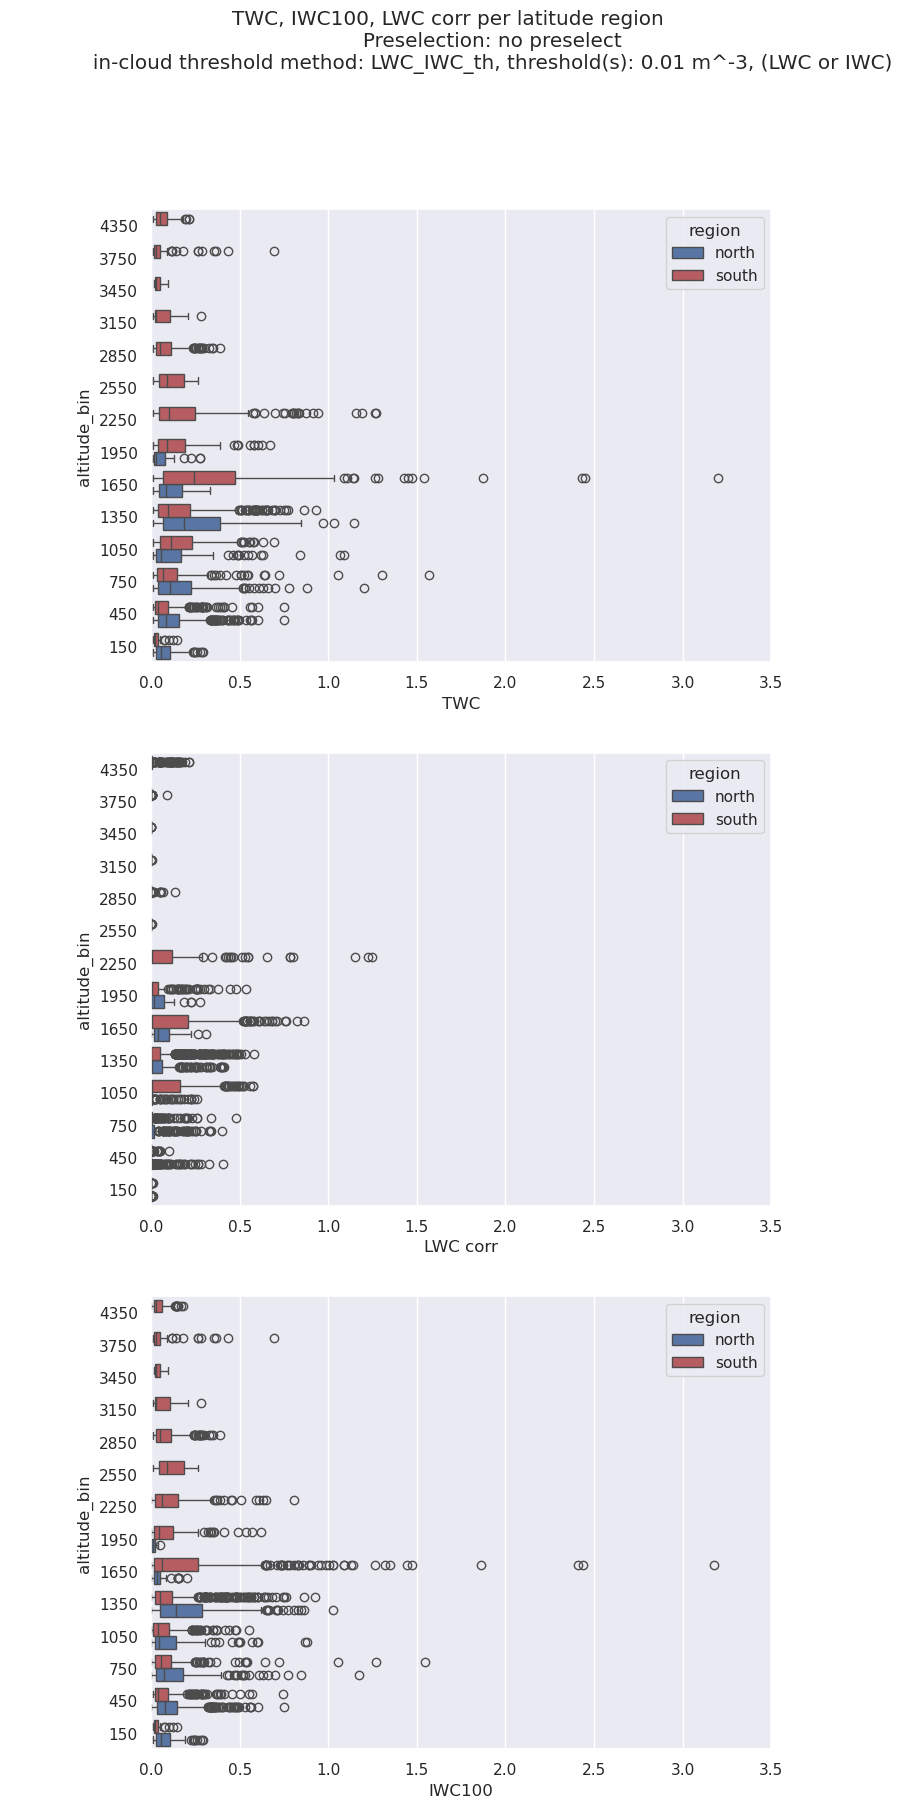

In [26]:
# -- BOXPLOT: Water contents, southern and northern in same plot (OLD)

import seaborn as sns

sns.set_theme(style='darkgrid')

fig, ax = plt.subplots(3,1, figsize=(8, 20))

sns.boxplot(data= ds_incloud, y ='altitude_bin', x='TWC', hue='region',  
            palette=dict(north='b', south='r'), 
            width=0.8, orient = 'h', ax=ax[0],
           showfliers=True)
sns.boxplot(data= ds_incloud, y ='altitude_bin', x='LWC corr', hue='region',  
            palette=dict(north='b', south='r'), 
            width=0.8, orient = 'h', ax=ax[1],
           showfliers=True)
sns.boxplot(data= ds_incloud, y ='altitude_bin', x='IWC100', hue='region',  
            palette=dict(north='b', south='r'), 
            width=0.8, orient = 'h', ax=ax[2],
           showfliers=True)

for a in ax:
    a.set_ylim(reversed(a.get_ylim()))  # Reversing the y-axis for each subplot

plt.setp(ax, xlim=(0, 3.5))  

# --- Figure 
plt.suptitle(f'{', '.join(str(e) for e in var)} per latitude region \n \
            Preselection: {pre_text}\n \
            in-cloud threshold method: {th_method}, threshold(s): {th}') # title
plt.savefig(save_path+f'{th_method}/seaborn_WC_per_Latitude_region_{th_method}{preopt}.png') # Save to
plt.show()

In [27]:
# -- southern marine
# get the mean values per height bin
s_twc_mean = south_df.groupby('altitude_bin')['TWC'].mean()
s_lwc_mean = south_df.groupby('altitude_bin')['LWC corr'].mean()
s_iwc_mean = south_df.groupby('altitude_bin')['IWC100'].mean()
s_t_mean = south_df.groupby('altitude_bin')['T'].mean() # temperature

# get the std values per height bin
s_twc_std = south_df.groupby('altitude_bin')['TWC'].std()
s_lwc_std = south_df.groupby('altitude_bin')['LWC corr'].std()
s_iwc_std = south_df.groupby('altitude_bin')['IWC100'].std()
s_t_std = south_df.groupby('altitude_bin')['T'].std()

# get the max values per height bin
s_twc_mx = south_df.groupby('altitude_bin')['TWC'].max()
s_lwc_mx = south_df.groupby('altitude_bin')['LWC corr'].max()
s_iwc_mx = south_df.groupby('altitude_bin')['IWC100'].max()
s_t_mx = south_df.groupby('altitude_bin')['T'].max()

# get the std values per height bin
s_twc_mn = south_df.groupby('altitude_bin')['TWC'].min()
s_lwc_mn = south_df.groupby('altitude_bin')['LWC corr'].min()
s_iwc_mn = south_df.groupby('altitude_bin')['IWC100'].min()
s_t_mn = south_df.groupby('altitude_bin')['T'].min()

# -- nothern marine
n_twc_mean = north_df.groupby('altitude_bin')['TWC'].mean()
n_lwc_mean = north_df.groupby('altitude_bin')['LWC corr'].mean()
n_iwc_mean = north_df.groupby('altitude_bin')['IWC100'].mean()
n_t_mean = north_df.groupby('altitude_bin')['T'].mean()

# get the std values per height bin
n_twc_std = north_df.groupby('altitude_bin')['TWC'].std()
n_lwc_std = north_df.groupby('altitude_bin')['LWC corr'].std()
n_iwc_std = north_df.groupby('altitude_bin')['IWC100'].std()
n_t_std = north_df.groupby('altitude_bin')['T'].std()

# get the max values per height bin
n_twc_mx = north_df.groupby('altitude_bin')['TWC'].max()
n_lwc_mx = north_df.groupby('altitude_bin')['LWC corr'].max()
n_iwc_mx = north_df.groupby('altitude_bin')['IWC100'].max()
n_t_mx = north_df.groupby('altitude_bin')['T'].max()

# get the std values per height bin
n_twc_mn = north_df.groupby('altitude_bin')['TWC'].min()
n_lwc_mn = north_df.groupby('altitude_bin')['LWC corr'].min()
n_iwc_mn = north_df.groupby('altitude_bin')['IWC100'].min()
n_t_mn = north_df.groupby('altitude_bin')['T'].min()

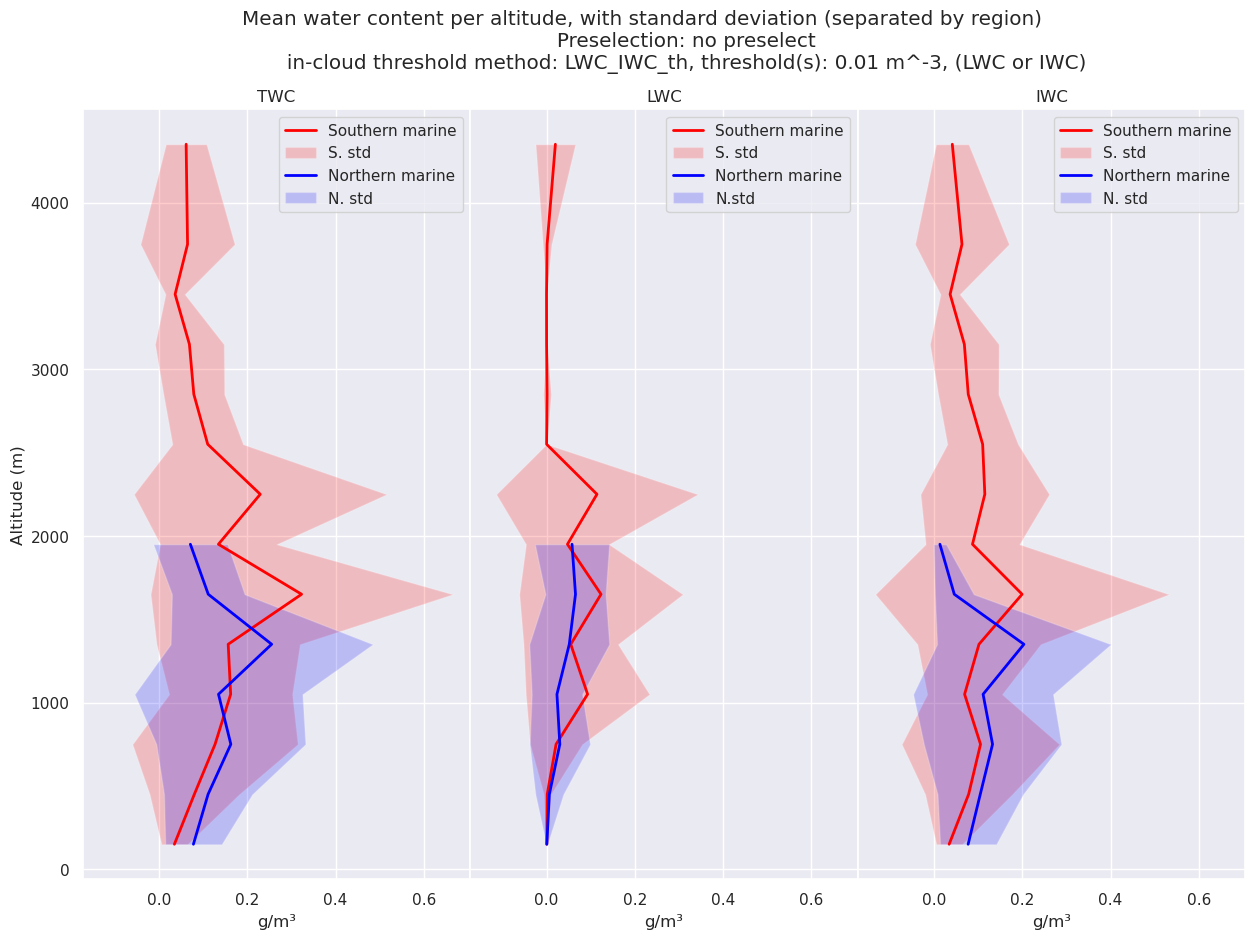

In [28]:
# plotting the mean and the spread (std) per height


# plot the values
fig = plt.figure(figsize=(15,10))
gs = fig.add_gridspec(1,3, wspace=0)
axs = gs.subplots(sharey=True, sharex=True)

# TWC southern and northern marine
axs[0].plot(s_twc_mean, s_twc_mean.index, label = 'Southern marine', lw=2,color = 'red')
axs[0].fill_betweenx(s_twc_mean.index, s_twc_mean+s_twc_std, s_twc_mean-s_twc_std, facecolor='red', alpha=0.2, label='S. std')

axs[0].plot(n_twc_mean, n_twc_mean.index, label = 'Northern marine', lw=2,color = 'blue')
axs[0].fill_betweenx(n_twc_mean.index, n_twc_mean+n_twc_std, n_twc_mean-n_twc_std, facecolor='blue', alpha=0.2, label='N. std')

axs[0].set_title('TWC')
axs[0].set_ylabel('Altitude (m)')
axs[0].set_xlabel('g/m³')
axs[0].legend(loc='upper right')


# LWC southern and northern marine
axs[1].plot(s_lwc_mean, s_lwc_mean.index, label = 'Southern marine', lw=2,color = 'red')
axs[1].fill_betweenx(s_lwc_mean.index, s_lwc_mean+s_lwc_std, s_lwc_mean-s_lwc_std, facecolor='red', alpha=0.2, label='S. std')

axs[1].plot(n_lwc_mean, n_lwc_mean.index, label = 'Northern marine', lw=2,color = 'blue')
axs[1].fill_betweenx(n_lwc_mean.index, n_lwc_mean+n_lwc_std, n_lwc_mean-n_lwc_std, facecolor='blue', alpha=0.2, label='N.std')

axs[1].set_title('LWC')
axs[1].set_xlabel('g/m³')
axs[1].legend(loc='upper right')


# IWC southern and northern marine
axs[2].plot(s_iwc_mean, s_iwc_mean.index, label = 'Southern marine', lw=2,color = 'red')
axs[2].fill_betweenx(s_iwc_mean.index, s_iwc_mean+s_iwc_std, s_iwc_mean-s_iwc_std, facecolor='red', alpha=0.2, label='S. std')

axs[2].plot(n_iwc_mean, n_iwc_mean.index, label = 'Northern marine', lw=2,color = 'blue')
axs[2].fill_betweenx(n_iwc_mean.index, n_iwc_mean+n_iwc_std, n_iwc_mean-n_iwc_std, facecolor='blue', alpha=0.2, label='N. std')

axs[2].set_title('IWC')
axs[2].set_xlabel('g/m³')
axs[2].legend(loc='upper right')


# --- Figure 
plt.suptitle(f'Mean water content per altitude, with standard deviation (separated by region) \n \
            Preselection: {pre_text}\n \
            in-cloud threshold method: {th_method}, threshold(s): {th}') # title
plt.savefig(save_path+f'{th_method}/mean_LWC_TWC_IWC_regionvise_{th_method}{preopt}.png') # Save to
plt.show()

In [43]:
altitude_bins

array([   0.,  300.,  600.,  900., 1200., 1500., 1800., 2100., 2400.,
       2700., 3000., 3300., 3600., 3900., 4200., 4500.])

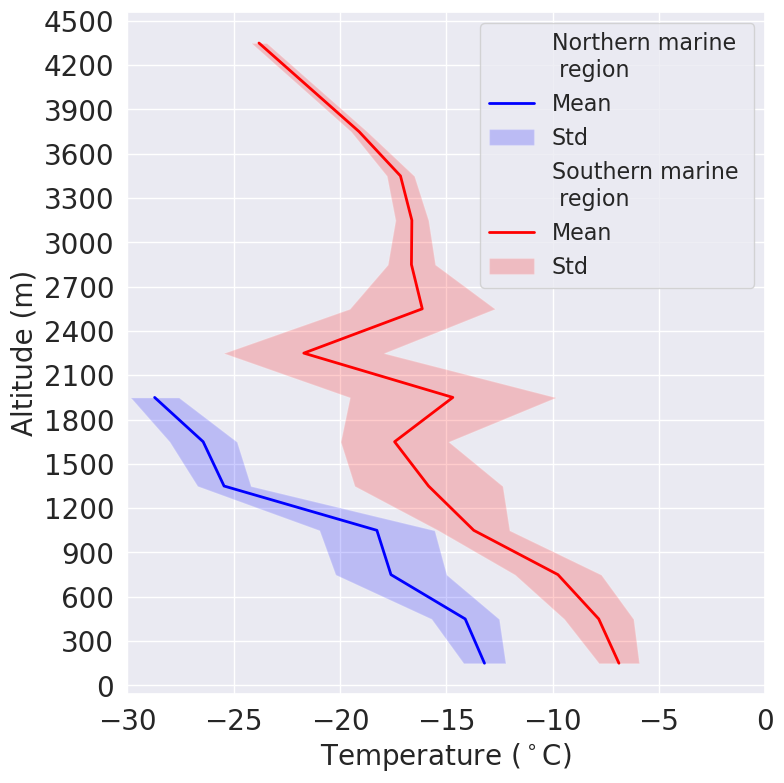

In [68]:
# mean temperature  per altitude per region, with standard deviation

# plot the values
fig, ax = plt.subplots(figsize=(8,8))

# Temperature southern and northern marine

# the comma is to get the first element of the list returned
nmn, = ax.plot(n_t_mean, n_t_mean.index, label = 'Northern \n marine region \n mean', lw=2,color = 'blue')
nstd = ax.fill_betweenx(n_t_mean.index, n_t_mean+n_t_std, n_t_mean-n_t_std, facecolor='blue', alpha=0.2, label='N.M.R. std')

smn, = ax.plot(s_t_mean, s_t_mean.index, label = 'Southern \n marine region \n mean', lw=2,color = 'red')
sstd = ax.fill_betweenx(s_t_mean.index, s_t_mean+s_t_std, s_t_mean-s_t_std, facecolor='red', alpha=0.2, label='S.M.R. std')


# Create to title legend
legend_handles = [nmn, nstd, smn, sstd]
legend_labels = ['Mean', 'Std', 'Mean', 'Std']

# Create a legend with titles and custom handles
from matplotlib.lines import Line2D

# Create custom legend handles for the two titles
title1 = Line2D([0], [0], color='none', label='Northern marine \n region', lw=0)  # Empty handle for title
title2 = Line2D([0], [0], color='none', label='Southern marine \n region', lw=0)  # Empty handle for title

# Combine the handles and labels
handles = [title1] + [legend_handles[0], legend_handles[1], title2, legend_handles[2], legend_handles[3]]
labels = [title1.get_label(),legend_labels[0], legend_labels[1], title2.get_label(), legend_labels[2], legend_labels[3]]

# Add legend to the plot
ax.legend(handles=handles, labels=labels, loc='upper right', fontsize=16)

ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_ylabel('Altitude (m)', fontsize = 20)
ax.set_xlabel('Temperature ($^\circ$C)', fontsize = 20)
ax.set_xlim([-30, 0])

# legend with two headlines:
#ax.legend(loc='upper right', fontsize=16)

plt.yticks(altitude_bins)


# --- Figure 
#plt.suptitle(f'Incloud temperature per altitude, with standard deviation (separated by region) \n \
#            Preselection: {pre_text}\n \
#            in-cloud threshold method: {th_method}, threshold(s): {th}') # title
#plt.title(f'In-cloud temperature per altitude, \n (regionvise)', fontsize=25)
plt.tight_layout()
plt.savefig(save_path+f'{th_method}/mean_T_regionvise_{th_method}{preopt}.png') # Save to
#plt.show()

## SLF plots 

In [40]:
# extracting the needed information from  the xarray to get ready for SLF plots

def create_SLF_df(ds):
    slf_data = ds['SLF_all'].values.flatten()  # Get the 'slf' values and flatten to 1D if required
    altitude_bin_data = ds['altitude_bin'].values  # Get 'altitude_bins' values
    time_data = ds['time'].values

    # Create a DataFrame
    df = pd.DataFrame({
        'time': time_data,
        'SLF': slf_data,
        'altitude_bin': altitude_bin_data
    })
    return df
    
north_df = create_SLF_df(north_ds)
south_df = create_SLF_df(south_ds)
mean_s = south_df.groupby('altitude_bin').mean('SLF')

 # -  make sure all possible altitude bins are represented, fill with 0
mean_s = mean_s.reindex(bin_labels, fill_value=0)

mean_s

,SLF
altitude_bin,
150.0,1.860786
450.0,1.330515
750.0,14.548999
1050.0,38.901465
1350.0,25.556224
1650.0,34.878954
1950.0,27.454363
2250.0,30.320484
2550.0,0.469415


In [41]:
count_df

,"[79, 78)","[78, 77)","[77, 76)","[76, 75)","[75, 74)","[74, 73)","[73, 72)","[72, 71)","[71, 70)"
altitude_bin,,,,,,,,,
4350.0,0,0,0,0,0,0,0,148,133
4050.0,0,0,0,0,0,0,0,0,0
3750.0,0,0,0,0,0,0,8,2,77
3450.0,0,0,0,0,0,0,11,0,10
3150.0,0,0,0,0,0,0,14,0,8
2850.0,0,0,0,0,0,0,157,263,12
2550.0,0,0,0,0,0,0,12,20,0
2250.0,0,0,0,0,0,0,36,84,35
1950.0,15,6,3,0,0,0,38,160,7


In [42]:
%skip
#does not work, check and add in later

# Calculate mean SLF per altitude bin (assuming bins are sorted)
    mean_slf_series = df.groupby('altitude_bin')['SLF'].mean()  # mean SLF values pr altitude bin
    mean_slf_df = mean_slf_series.reset_index() # turn into a dataframe with the altitude_bins
    mean_slf_df.columns = ['altitude_bin', 'mean_slf'] #rename columns
    mean_slf_df.set_index('altitude_bin', inplace=True) # use altitude_bins as index
    mean_slf_df = mean_slf_df.reindex(bin_labels, fill_value=0) #make sure all possible altitude bins are represented, fill with 0
    mean_slf_df = mean_slf_df.iloc[::-1]
    print(mean_slf_df)
    
    # Create overlay plot
    ax_mean = f.add_axes(ax_main.get_position(), frameon=False)
    ax_mean.plot(mean_slf_df['mean_slf'],mean_slf_df.index, color='red', label='Mean SLF')
    ax_mean.set_xlim(0,100)
    ax_mean.set_ylim(ax_main.get_ylim())
    ax_mean.set_yticks([])
    ax_mean.set_xticks(ax_main.get_xticks())

    ax_mean.legend(loc='upper right')

IndentationError: unexpected indent (513937008.py, line 5)

Normalize!
Normalize!
                      5        10        15        20        25        30  \
altitude_bin                                                                
4350.0         0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
4050.0         0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
3750.0         0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
3450.0         0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
3150.0         0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2850.0         0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2550.0         0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2250.0         0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1950.0        29.166667  0.000000  0.000000  0.000000  4.166667  4.166667   
1650.0        14.285714  6.349206  3.174603  3.174603  0.000000  1.587302   
1350.0        57.507987  5.750799  3.194888  6.070288 

Normalize!
Normalize!


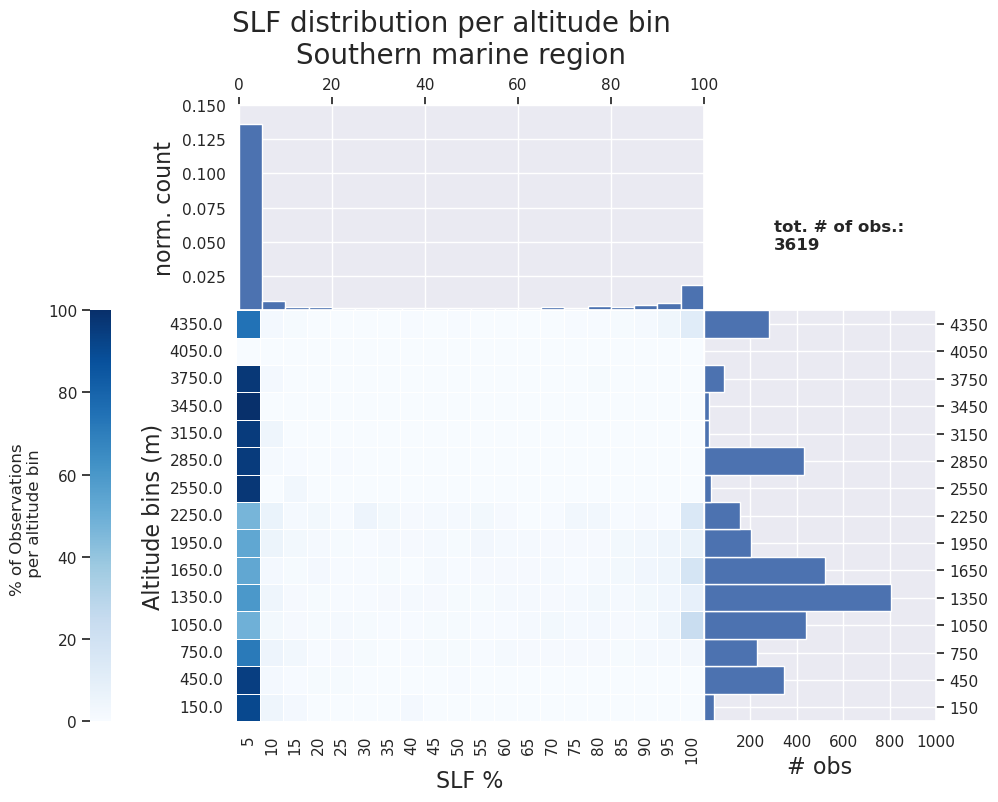

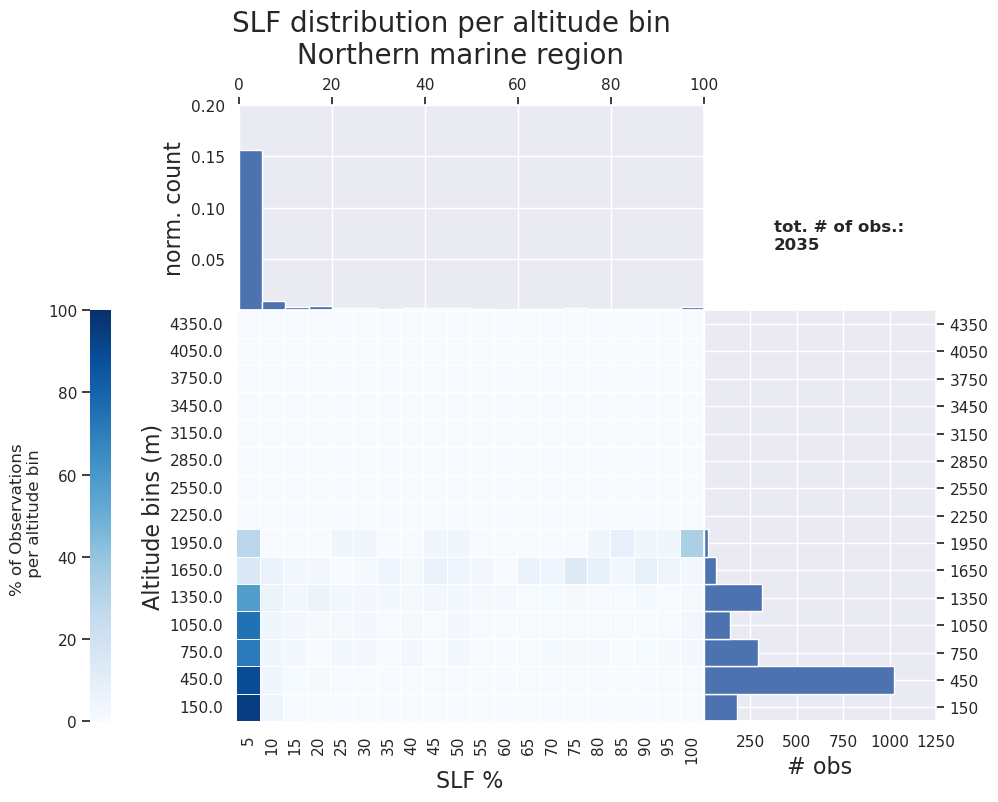

In [42]:
north_top_ds
#north_bulk_ds
north_ds

<xarray.Dataset> Size: 3MB
Dimensions:                 (time: 728, Vector64: 64, Vector40: 40, CDP_Bin: 30)
Coordinates:
  * time                    (time) datetime64[ns] 6kB 2022-03-24T10:46:24 ......
  * CDP_Bin                 (CDP_Bin) int64 240B 1 2 3 4 5 6 ... 26 27 28 29 30
    lat                     (time) float32 3kB 76.63 76.65 76.66 ... 75.01 75.0
    lon                     (time) float32 3kB 10.95 10.94 10.94 ... 20.89 20.89
    alt                     (time) float32 3kB 1.873e+03 1.725e+03 ... 406.3
    altitude_bin            (time) int64 6kB 1950 1650 1650 1650 ... 450 450 450
Dimensions without coordinates: Vector64, Vector40
Data variables: (12/80)
    base_time               (time) datetime64[ns] 6kB 2022-03-24T08:04:25 ......
    utc_time                (time) float64 6kB dask.array<chunksize=(728,), meta=np.ndarray>
    TAS                     (time) float32 3kB dask.array<chunksize=(728,), meta=np.ndarray>
    MIDBINS                 (time, Vector64) float32 186kB dask.array<chunksize=(728, 64), meta=np.ndarray>
    ACTIVETIME              (time) float32 3kB dask.array<chunksize=(728,), meta=np.ndarray>
    SA                      (time, Vector64) float32 186kB dask.array<chunksize=(728, 64), meta=np.ndarray>
    ...                      ...
    surface_cond            (time) object 6kB dask.array<chunksize=(728,), meta=np.ndarray>
    in_cloud_lwc            (time) float64 6kB dask.array<chunksize=(728,), meta=np.ndarray>
    in_cloud_twc            (time) float64 6kB dask.array<chunksize=(728,), meta=np.ndarray>
    in_cloud                (time) float64 6kB dask.array<chunksize=(728,), meta=np.ndarray>
    Relevance               (time) object 6kB dask.array<chunksize=(728,), meta=np.ndarray>
    region                  (time) object 6kB 'north' 'north' ... 'north'
Attributes:
    date_modified:              2025-04-04
    Joint dataset sample rate:  5.0
    CDP sample area:            0.269
    CDP sample area unit:       mm²
    incloud_thres:              0.01

In [92]:
# Histplots for the top layer of the north and the south
fig, ax = plt.subplots(1, 1, figsize=(10, 8), layout="constrained", sharey=True)
    

ax.hist(midbins[3:], weights=weights[3:], bins=midbins[3:], label="mean area ratio", color='grey', histtype='stepfilled', alpha=0.3)# Plot first three bins in grey
#ax.hist(midbins[3:], weights=min_arear[3:], bins=midbins[3:], label="CIP", histtype='stepfilled', alpha = 0.5)
ax.plot(midbins[3:], weights[3:], label = 'test')


# set labels, titles and legends for subplots
ax.set_ylabel(ds_incloud['MEAN_AREARATIO'].attrs['long_name'])
ax.set_xlabel('Size ($\mu$m)')
#ax.set_title(cat_text)
ax.legend(loc='upper right')

# --- Subplot settings
ax.grid(True)
ax.yaxis.set_tick_params(which='both', labelleft=True)
ax.xaxis.set_tick_params(which='both', labelbottom=True)

# --- Figure 
#plt.suptitle(f'Nort \n \
            Preselection: {pre_text}\n \
            in-cloud threshold method: {th_method}, threshold(s): {th}') # title
#plt.savefig(save_path+f'{th_method}/Nt_Latitude_bands_{th_method}{preopt}.png') # Save to
plt.show()


In [ ]:
# Calculate mean SLF per altitude bin (assuming bins are sorted)
mean_slf = df.groupby('altitude_bin')['SLF'].mean().values  # mean SLF values pr altitude bin
mean_slf = pd.Series(mean_slf) # turn into panda series for reindexing
mean_slf = mean_slf.reindex(bin_labels, fill_value=0) #make sure all possible altitude bins are represented, fill with 0
# Plotting the mean SLF as a line
ax_main.plot(bin_labels, mean_slf, color='red', linewidth=2, label='Mean SLF', marker='



In [52]:
north_ds

<xarray.Dataset> Size: 3MB
Dimensions:                 (time: 728, Vector64: 64, Vector40: 40, CDP_Bin: 30)
Coordinates:
  * time                    (time) datetime64[ns] 6kB 2022-03-24T10:46:24 ......
  * CDP_Bin                 (CDP_Bin) int64 240B 1 2 3 4 5 6 ... 26 27 28 29 30
    lat                     (time) float32 3kB 76.63 76.65 76.66 ... 75.01 75.0
    lon                     (time) float32 3kB 10.95 10.94 10.94 ... 20.89 20.89
    alt                     (time) float32 3kB 1.873e+03 1.725e+03 ... 406.3
    altitude_bin            (time) int64 6kB 1950 1650 1650 1650 ... 450 450 450
Dimensions without coordinates: Vector64, Vector40
Data variables: (12/80)
    base_time               (time) datetime64[ns] 6kB 2022-03-24T08:04:25 ......
    utc_time                (time) float64 6kB dask.array<chunksize=(728,), meta=np.ndarray>
    TAS                     (time) float32 3kB dask.array<chunksize=(728,), meta=np.ndarray>
    MIDBINS                 (time, Vector64) float32 186kB dask.array<chunksize=(728, 64), meta=np.ndarray>
    ACTIVETIME              (time) float32 3kB dask.array<chunksize=(728,), meta=np.ndarray>
    SA                      (time, Vector64) float32 186kB dask.array<chunksize=(728, 64), meta=np.ndarray>
    ...                      ...
    surface_cond            (time) object 6kB dask.array<chunksize=(728,), meta=np.ndarray>
    in_cloud_lwc            (time) float64 6kB dask.array<chunksize=(728,), meta=np.ndarray>
    in_cloud_twc            (time) float64 6kB dask.array<chunksize=(728,), meta=np.ndarray>
    in_cloud                (time) float64 6kB dask.array<chunksize=(728,), meta=np.ndarray>
    Relevance               (time) object 6kB dask.array<chunksize=(728,), meta=np.ndarray>
    region                  (time) object 6kB 'north' 'north' ... 'north'
Attributes:
    date_modified:              2025-04-04
    Joint dataset sample rate:  5.0
    CDP sample area:            0.269
    CDP sample area unit:       mm²
    incloud_thres:              0.01

In [104]:
# Create dataframe for visualizing available observations with Heatmap
north_df

,time,SLF,altitude_bin,SLF_bins
0,2022-03-24 10:46:24,92.885555,1950,"(90.0, 95.0]"
1,2022-03-24 10:46:49,15.219889,1650,"(15.0, 20.0]"
2,2022-03-24 10:46:59,85.541884,1650,"(85.0, 90.0]"
3,2022-03-24 10:47:04,62.419927,1650,"(60.0, 65.0]"
4,2022-03-24 10:47:09,7.407537,1650,"(5.0, 10.0]"
...,...,...,...,...
723,2022-04-03 14:54:34,93.234530,450,"(90.0, 95.0]"
724,2022-04-03 14:55:19,86.430664,450,"(85.0, 90.0]"
725,2022-04-03 14:55:24,74.334156,450,"(70.0, 75.0]"
726,2022-04-03 14:55:29,97.615749,450,"(95.0, 100.0]"


Text(78.75, 0.5, 'Altitude Bins (300 m)')

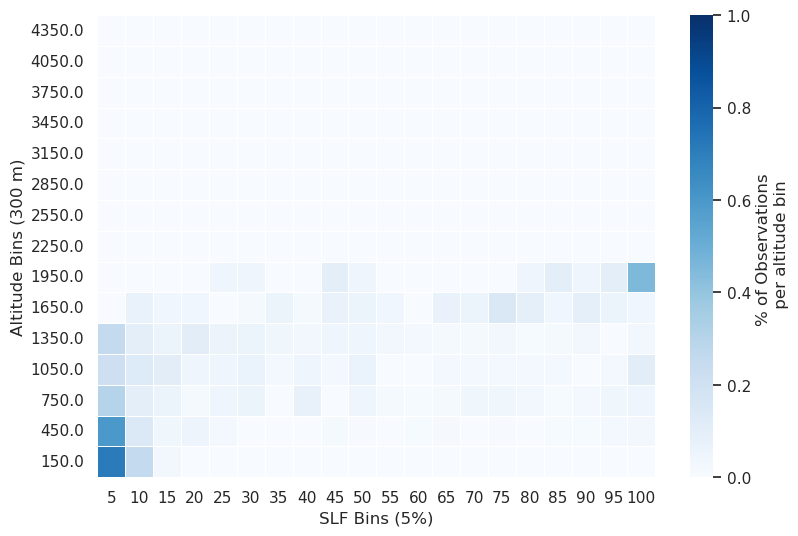

In [109]:
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(ncount_df, cmap='Blues', ax=ax, 
            cbar_kws={"label": "% of Observations \n per altitude bin"}, vmin=0, vmax=1,
            linewidths=0.5)

plt.xlabel('SLF Bins (%)')
plt.ylabel('Altitude Bins (m)')


SLF_bins,"(-0.001, 5.0]","(5.0, 10.0]","(10.0, 15.0]","(15.0, 20.0]","(20.0, 25.0]","(25.0, 30.0]","(30.0, 35.0]","(35.0, 40.0]","(40.0, 45.0]","(45.0, 50.0]","(50.0, 55.0]","(55.0, 60.0]","(60.0, 65.0]","(65.0, 70.0]","(70.0, 75.0]","(75.0, 80.0]","(80.0, 85.0]","(85.0, 90.0]","(90.0, 95.0]"
altitude_bin,,,,,,,,,,,,,,,,,,,
4350.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4050.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3750.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3450.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3150.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2850.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2550.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2250.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1950.0,0.000000,0.000000,0.000000,0.000000,0.090909,0.090909,0.000000,0.000000,0.181818,0.090909,0.000000,0.000000,0.000000,0.000000,0.000000,0.090909,0.181818,0.090909,0.181818
